In [1]:

from __future__ import division
import matplotlib.pyplot as plt
import h5py
import numpy as np 
from ripser import Rips, ripser
from sklearn import preprocessing
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from scipy.stats import binned_statistic
from scipy.sparse import coo_matrix
from scipy.linalg import eigh
from scipy.sparse.linalg import lsmr
from scipy import stats
import scipy.io as sio
from scipy.interpolate import CubicSpline
from sklearn.cluster import AgglomerativeClustering
import umap
from datetime import datetime 
import time
import functools
from scipy import signal
from scipy import optimize
import sys
import numba
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec, transforms
from scipy.special import factorial
import pickle
import glob
import re
import os


gen_fn_dir = os.path.abspath('..') + '/shared_scripts'
sys.path.append(gen_fn_dir)


def match_spikes_to_cells(cluster_file_path, timing_file_path, verbose=True):
    '''
    Uses .clu and .res files to associate spike times with putative cells.
    
    Parameters
    ----------
    cluster_file_path: str
        path to .clu file associated with a session and shank
    timing_file_path: str
        path to .res file associated with same session and shank
    
    Returns
    -------
    nCells: int or nan
        number of cells on a given shank,  nan if no cells present
    spike_times: list
        list of floats indicating times where a spike occurred for a cluster
    '''
    print(cluster_file_path)
    print(timing_file_path)

    tmp_clusters = read_numerical_file(cluster_file_path, 'int', 'single')
    tmp_spikes = read_numerical_file(timing_file_path, 'float', 'single')
#    print('clu',cluster_file_path, tmp_clusters)
#    print('clu',timing_file_path, tmp_spikes)
    
    if verbose:
        print( 'Cluster file:', cluster_file_path, 'Timing file ', timing_file_path)

    # First line in cluster file is number of cells (with 0 corresponding to
    # artifacts and 1 to noise)
    nClusters = tmp_clusters[0]
    cluster_ids = list(tmp_clusters[1:])
    if nClusters <= 2:  # ony clusters are 0 and 1; so no cells
        print( 'No cells found')
        nCells = 0
        spike_times = []
        return nCells, spike_times
    if np.max(cluster_ids) != (nClusters - 1):  
        print( 'Clusters listed at beginning of file do not agree')
        nCells = np.nan
        spike_times = []
        return nCells, spike_times

    # Now break this up in various cells
    spike_time_list = [[] for i in range(nClusters)]

    for i in range(len(cluster_ids)):
        spike_time_list[cluster_ids[i]].append(tmp_spikes[i])

    spike_times_incl_noise = [np.array(x) for x in spike_time_list]
    spike_times = spike_times_incl_noise[2:]
    nCells = nClusters - 2  # since 0/1 are noise; subtract from nCluster

    return nCells, spike_times

def gather_session_spike_info(params, verbose=True):
    '''Gather data from the downloaded files.
    For each session we have (a) State information (Wake, REM, SWS), 
    (b) Position and angle info
    and (c) Spike info.
    '''

    session = params['session']
    curr_data_path = params['data_path']
    file_tag = curr_data_path + session
    if verbose:
        print( 'Session: ', session)
        print( curr_data_path)
    # First store the times the animal was in each state in state_times
    state_file_base = file_tag + '.states.'
    state_names = ['Wake', 'REM', 'SWS']

    state_times = {st: read_numerical_file(state_file_base + st, 'float', 'multiple') 
        for st in state_names}

    # Store head direction in angle_list along with the corresponding times recorded.
    angle_list_orig = []#read_numerical_file(file_tag + '.ang', 'float', 'single')
    print(angle_list_orig)
    # When angle couldn't be sampled, these files have -1. But this could mess up 
    # averaging if we're careless, so replace it with NaNs.
    angle_list = np.array(angle_list_orig)
    angle_list[angle_list < -0.5] = np.nan

    # Tag angles with the times at which they were sampled.
    pos_sampling_rate = params['eeg_sampling_rate'] / 32.  # Hz
    angle_times = np.arange(len(angle_list)) / pos_sampling_rate

    # Spike times.
    # There is a .res and .clu file for each shank.
    # .res file contains spike times. .clu contains putative cell identities.
    # Files are of the form session.clu.dd and session.res.dd, where dd is the shank number.
    # The first line in each clu file is the number of clusters for that shank, with clusters
    # 0 and 1 indicating artefacts and noise. So ignore those clusters and start with cluster number
    # 2 as cell number 0.
    # The length of the cluster file should be 1 entry more than the length of the spike 
    # timing files (because the first line is the number of clusters).
    # Note that there are occasionally extra .clu files, from previous rounds of sorting
    # so we want to exclude them. 
    print(curr_data_path + session)
    nShanks = len(
        [fname for fname in glob.glob(curr_data_path + session + '.clu.*') #if re.match(
    #    file_tag + '.clu.\\d+$', fname)
        ])
    print(nShanks)
    if verbose:
        print( 'Number of shanks =', nShanks)
    nCells_per_shank = np.zeros(nShanks)
    
    # Store spike times as dict where keys are (shank, cell) and the values
    # are spike times for that cell. We index shanks starting at 0 but these files 
    # are stored starting from 1, so make sure to subtract 1 where relevant.
    spike_times = {}

    for pyth_shank_idx in range(nShanks):
        data_shank_idx = pyth_shank_idx + 1
        print( '\nAnalyzing shank', data_shank_idx)
        cluster_file = file_tag + '.clu.' + str(data_shank_idx)
        timing_file = file_tag + '.res.' + str(data_shank_idx)

        nCells_per_shank[pyth_shank_idx], tmp_spike_list = match_spikes_to_cells(
            cluster_file, timing_file)
        
        nCells_current = nCells_per_shank[pyth_shank_idx]
        if nCells_current > 0:  # if the shank has actual cells
            # loops over each cell
            for curr_cell in range(int(nCells_current)):
                # Multiply by spike sampling interval to get into units of time
                # For reference this is 1.0/(20e3)
                spike_times[(pyth_shank_idx, curr_cell)] = params[
                    'spike_sampling_interval'] * tmp_spike_list[curr_cell]

    # Check for shanks where the number of clusters doesn't equal number of listed cells
    wrong_count_shanks = np.sum(np.isnan(nCells_per_shank))
    if wrong_count_shanks and verbose:
        print( '\nThe number of shanks with wrong number of cells listed is', wrong_count_shanks)

    # Gather up stuff and return it
    data_to_return = {'session' : session, 'state_times' : state_times, 'angle_list' : 
        np.array(angle_list), 'pos_sampling_rate': pos_sampling_rate, 'angle_times' : 
        np.array(angle_times), 'nShanks': nShanks, 'nCells': nCells_per_shank, 
        'spike_times': spike_times, 'cells_with_weird_clustering': wrong_count_shanks}

    return data_to_return

def load_file_from_pattern(file_pattern):
    file_matches = glob.glob(file_pattern)
    if len(file_matches)>1:
        print('Multiple matches. Using the first one')
    if len(file_matches)==0:
        print('No file found')
        return
    fname = file_matches[0]
    data = load_pickle_file(fname)
    return data, fname

def load_pickle_file(filename):
    fr = open(filename, 'rb')
    data = pickle.load(fr)#, encoding='Latin-1',  errors='ignore')
    fr.close()
    return data

def save_pickle_file(data, filename):
    fw = open(filename, 'wb')
    pickle.dump(data, fw)
    fw.close()
    return 1

def return_dir(input_dir):
    '''Makes the directory input_dir if it doesn't exist.
    Return input_dir.'''
    if not os.path.exists(input_dir):
        print('Making %s'%input_dir)
        os.makedirs(input_dir)
    return input_dir

def read_numerical_file(path, data_type, list_type):
    '''
    Reads in a file consisting of UTF-8 encoded lists of numbers with single or 
    multiple observations per line.

    Parameters
    ----------
    path: str or Path object
        file to be read
    data_type: int or float
        data type of the observations in the file
    list_type: str
        'single'
            single observations per line
        'multiple'
            multiple observations per line
    
    Returns
    -------
    data_list: list
        Simple list of single values, or if 'multiple' data type then nested lists for each
        line in input file
    '''
    if data_type not in ('float', 'int'):
        raise ValueError('Must specify either \'float\' or \'int\' as data_type')
    if list_type not in ('single', 'multiple'):
        raise ValueError('list type must be \'single\' or \'multiple\'')
    fr = open(path, 'r')
    if data_type == 'int':
        d_type = int
    elif data_type == 'float':
        d_type = float
    
    if list_type == 'single':
        data_list = [d_type(line.rstrip()) for line in fr]
    elif list_type == 'multiple':
        data_list = [[d_type(y) for y in line.split()] for line in fr]
    fr.close()
    return data_list
def get_coords(cocycle, threshold, num_sampled, dists, coeff):
    zint = np.where(coeff - cocycle[:, 2] < cocycle[:, 2])
    cocycle[zint, 2] = cocycle[zint, 2] - coeff
    d = np.zeros((num_sampled, num_sampled))
    d[np.tril_indices(num_sampled)] = np.NaN
    d[cocycle[:, 1], cocycle[:, 0]] = cocycle[:, 2]
    d[dists > threshold] = np.NaN
#    d[dists == 0] = np.NaN
    edges = np.where(~np.isnan(d))
    verts = np.array(np.unique(edges))
    num_edges = np.shape(edges)[1]
    num_verts = np.size(verts)

    values = d[edges]
    A = np.zeros((num_edges, num_verts), dtype=int)
    v1 = np.zeros((num_edges, 2), dtype=int)
    v2 = np.zeros((num_edges, 2), dtype=int)
    for i in range(num_edges):
        v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
        v2[i, :] = [i, np.where(verts == edges[1][i])[0]]

    A[v1[:, 0], v1[:, 1]] = -1
    A[v2[:, 0], v2[:, 1]] = 1

    L = np.ones((num_edges,))
    Aw = A * np.sqrt(L[:, np.newaxis])
    Bw = values * np.sqrt(L)

    f = lsmr(Aw, Bw)[0]%1
    return f, verts

def get_coords_ds(rips_real, len_indstemp, ph_classes = [0,1], dec_thresh = 0.99, coeff = 47):
    num_circ = len(ph_classes)    
    ################### Decode coordinates ####################
    diagrams = rips_real["dgms"] # the multiset describing the lives of the persistence classes
    cocycles = rips_real["cocycles"][1] # the cocycle representatives for the 1-dim classes
    dists_land = rips_real["dperm2all"] # the pairwise distance between the points 
    births1 = diagrams[1][:, 0] #the time of birth for the 1-dim classes
    deaths1 = diagrams[1][:, 1] #the time of death for the 1-dim classes
    deaths1[np.isinf(deaths1)] = 0
    lives1 = deaths1-births1 # the lifetime for the 1-dim classes
    iMax = np.argsort(lives1)
    coords1 = np.zeros((num_circ, len_indstemp))
    for j,c in enumerate(ph_classes):
        cocycle = cocycles[iMax[-(c+1)]]
        threshold = births1[iMax[-(c+1)]] + (deaths1[iMax[-(c+1)]] - births1[iMax[-(c+1)]])*dec_thresh
        coordstemp,inds = get_coords(cocycle, threshold, len_indstemp, dists_land, coeff)
        coords1[j,inds] = coordstemp
    return coords1

def get_coords_all(sspikes2, coords1, times_cube, indstemp, dim = 7, spk2 = [], bPred = False, bPCA = False):
    num_circ = len(coords1)
    spkmean = np.mean(sspikes2[times_cube,:], axis = 0)
    spkstd = np.std(sspikes2[times_cube,:], axis = 0)
    spkscale = (sspikes2-spkmean)/spkstd
    dspk1 = spkscale.copy()
    if bPCA:
        __, e1, e2,__ = pca(spkscale[times_cube,:], dim = dim)
        dspk1 = np.dot(e1.T, spkscale.T).T    
        dspk1 /= np.sqrt(e2)    
        
    dspk = dspk1[indstemp,:]
    if len(spk2)>0:
        dspk1 = (spk2-spkmean)/spkstd
        if bPCA:
            dspk1 = np.dot(e1.T, dspk1.T).T    
            dspk1 /= np.sqrt(e2)    


    if bPred:
        coords_mod1 = np.zeros((len(sspikes2), num_circ))
        coords_mod1[:,0] = predict_color(coords1[0,:], dspk1, dspk, 
                                     dist_measure='cosine',  k = 30)
        coords_mod1[:,1] = predict_color(coords1[1,:],  dspk1, dspk,
                                         dist_measure='cosine',  k = 30)
    else:
        num_neurons = len(dspk[0,:])
        centcosall = np.zeros((num_neurons, num_circ, len(indstemp)))
        centsinall = np.zeros((num_neurons, num_circ, len(indstemp)))    
        for neurid in range(num_neurons):
            spktemp = dspk[:, neurid].copy()
            centcosall[neurid,:,:] = np.multiply(np.cos(coords1[:, :]*2*np.pi),spktemp)
            centsinall[neurid,:,:] = np.multiply(np.sin(coords1[:, :]*2*np.pi),spktemp)

        a = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            a[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centcosall[n,:,:],1))

        c = np.zeros((len(dspk1), num_circ, num_neurons))
        for n in range(num_neurons):
            c[:,:,n] = np.multiply(dspk1[:,n:n+1],np.sum(centsinall[n,:,:],1))

        mtot2 = np.sum(c,2)
        mtot1 = np.sum(a,2)
        coords_mod1 = np.arctan2(mtot2,mtot1)%(2*np.pi)
    return coords_mod1

def get_cross(mouse_sess, data, spike_times1, data_dir = 'Data', spike_times = [], files = ['Wake', 'REM', 'SWS']):
    crosscorrfile = glob.glob(data_dir + '/' + mouse_sess + '_crosscorr_train2.npz')
    if len(crosscorrfile)>0:
        f = np.load(crosscorrfile[0], allow_pickle = True)
        crosscorr_train = f['crosscorr_train'][()]
        f.close()
    else:
        sspk1_cross = {}
        res = 100000
        sigma = 30000
        dt = 3000
        lencorr = 30
        thresh = sigma*5
        num_thresh = int(thresh/dt)
        num2_thresh = int(2*num_thresh)
        sig2 = 1/(2*(sigma/res)**2)
        ker = np.exp(-np.power(np.arange(thresh+1)/res, 2)*sig2)
        kerwhere = np.arange(-num_thresh,num_thresh)*dt
        for brain_state in files:
            t_curr =  data['state_times'][brain_state]
            res = 100000

            if brain_state == 'SWS':
                sigma = 10000
                dt = 200000
            else:
                sigma = 100000
                dt = 50000
            thresh = sigma*20
            num_thresh = int(thresh/dt)
            num2_thresh = int(2*num_thresh)
            sig2 = 1/(2*(sigma/res)**2)
            ker = np.exp(-np.power(np.arange(thresh+1)/res, 2)*sig2)
            kerwhere = np.arange(-num_thresh,num_thresh)*dt

            spikes_bin_tmp = np.zeros((1,len(spike_times1)))
            for ttmp in t_curr:
                min_time = ttmp[0]*res
                max_time = ttmp[-1]*res
                tt = np.arange(np.floor(min_time), np.ceil(max_time)+1, dt)

                spikes_temp = np.zeros((len(tt)+num2_thresh, len(spike_times1)))
                for n, spk in enumerate(spike_times1):
                    spk = spike_times1[spk]
                    spikes = np.array(spk*res-min_time, dtype = int)
                    spikes = spikes[(spikes < (max_time-min_time)) & (spikes > 0)]
                    spikes_mod = dt-spikes%dt
                    spikes = np.array(spikes/dt, int)
                    for m, j in enumerate(spikes):
                        spikes_temp[j:j+num2_thresh, n] += ker[np.abs(kerwhere+spikes_mod[m])]
                spikes_temp = spikes_temp[num_thresh-1:-(num_thresh+1),:]
                spikes_bin_tmp = np.concatenate((spikes_bin_tmp, spikes_temp),0)
            spikes_bin[brain_state] = spikes_bin_tmp[1:,:]
            spikes_bin[brain_state] *= 1/np.sqrt(2*np.pi*(sigma/res)**2)

        ################### Get crosscorrs ####################    
        crosscorr_train = {}
        for fi in files[:]:
            sspk1_d = spikes_bin[fi].copy().astype(float)        
            num_neurons = len(sspk1_d[0,:])
            crosscorrs = np.zeros((len(sspk1_d[0,:]), len(sspk1_d[0,:]), lencorr))
            spksum = np.sum(sspk1_d,0)
            for i in range(num_neurons):
                spktemp = np.concatenate((sspk1_d[:,i], np.zeros(lencorr)))
                lenspk = len(sspk1_d[:,i])
                for j in range(num_neurons):
                    if j == i:
                        continue
                    for t1 in range(lencorr):
                        crosscorrs[i,j,t1] = np.dot(sspk1_d[:,j],np.roll(spktemp, t1)[:lenspk])
                    crosscorrs[i,j,:] /= (spksum[j]*spksum[i])
            crosscorr_train[fi] = crosscorrs.copy()
        np.savez(data_dir + '/' + mouse_sess + '_crosscorr_train2', crosscorr_train = crosscorr_train)
    return crosscorr_train

def get_ind(mouse_sess, crosscorr_train, data_dir = 'giocomo_figures_final12', files = [], nbs = -1):
    ################### Get crosscorr stats ####################  
    num_neurons = len(crosscorr_train[files[0]])
    crosscorrs = np.zeros((num_neurons,num_neurons))
    for fi in files: 
        fi1 = fi.replace('\\', '/')
        crosscorrs_tmp = crosscorr_train[fi1].copy()
        num_neurons = len(crosscorrs_tmp[:,0,0])
        for i in range(num_neurons):
            for j in np.arange(i+1, num_neurons):
                a = crosscorrs_tmp[i,j,:]
                b = crosscorrs_tmp[j,i,:]
                c = np.concatenate((a,b))
                if np.min(c)>0:
                    crosscorrs[i,j] +=  np.square(np.min(c)/np.max(c))/len(files)
                crosscorrs[j,i] = crosscorrs[i,j]
    
    crosscorrs[np.isnan(crosscorrs)] = 1
    crosscorrs[np.isinf(crosscorrs)] = 1
    agg = AgglomerativeClustering(n_clusters=None,affinity='precomputed', linkage='average', 
                                  distance_threshold=nbs)
    ind = agg.fit(crosscorrs).labels_
    
    fig = plt.figure()
    crosscorrs = crosscorrs[np.argsort(ind), :]
    crosscorrs = crosscorrs[:, np.argsort(ind)]    
    plt.imshow(crosscorrs)
    return ind

def get_dgms(sspikes2, maxdim = 1, omega = 1, k  = 1000, 
    n_points = 800, dim = 7, nbs = 800, eps = 1, metric = 'cosine', indstemp = []):    
    dgms_all = {}
    dim_red_spikes_move_scaled = preprocessing.scale(sspikes2, axis = 0)
    dim_red_spikes_move_scaled, e1, e2, var_exp = pca(dim_red_spikes_move_scaled, dim = dim)
    dim_red_spikes_move_scaled /= np.sqrt(e2[:dim])
    if len(indstemp)==0:
        startindex = np.argmax(np.sum(np.abs(dim_red_spikes_move_scaled),1))
        if eps > 0:
            movetimes1 = radial_downsampling(dim_red_spikes_move_scaled, metric = 'euclidean', epsilon = eps, 
                startindex = startindex)
        else:
            movetimes1 = np.arange(len(dim_red_spikes_move_scaled))
        indstemp,__  = sample_denoising(dim_red_spikes_move_scaled[movetimes1,:],  k, 
                                           n_points, omega, metric)
        indstemp = movetimes1[indstemp]
    else:
        movetimes1 = []
    dim_red_spikes_move_scaled = dim_red_spikes_move_scaled[indstemp,:]
    X = squareform(pdist(dim_red_spikes_move_scaled[:,:], metric))
    knn_indices = np.argsort(X)[:, :nbs]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()
    sigmas, rhos = smooth_knn_dist(knn_dists, nbs, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(X.shape[0], X.shape[0]))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)
    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    d = result.toarray()
    d = -np.log(d)
    np.fill_diagonal(d,0)
    thresh = np.max(d[~np.isinf(d)])
    if maxdim == 2:
        hom_dims = list(range(maxdim+1))
        VR = VietorisRipsPersistence(
        homology_dimensions=hom_dims,
        metric='precomputed',
        coeff=47,
        max_edge_length= thresh,
        collapse_edges=False,  # True faster?
        n_jobs=None  # -1 faster?
        )
        diagrams = VR.fit_transform([d])
        dgms_all[0] = from_giotto_to_ripser(diagrams[0])
        persistence = []
    else:
        persistence = ripser(d, maxdim=1, coeff=47, do_cocycles= True, distance_matrix = True, thresh = thresh)    
        dgms_all[0] = persistence['dgms'] 
    return dgms_all, persistence, indstemp, movetimes1, var_exp

def plot_barcode(persistence, file_name = '', shuffle_name = ''):
    if np.sum(np.isinf(persistence[0])) == 0:
        persistence[0] = np.concatenate((persistence[0], np.array([0,np.inf])[np.newaxis, :]),0)

    diagrams_roll = {}
    if len(shuffle_name)>0:
        f = np.load(shuffle_name + '.npz', allow_pickle = True)
        diagrams_roll = f['dgms_shuffles'][()]
        f.close() 

    alpha=1
    inf_delta=0.1
    legend=True
    maxdim = len(persistence)-1
    cs = np.repeat([[0,0.55,0.2]],maxdim+1).reshape(3, maxdim+1).T
    colormap=cs
    dims =np.arange(maxdim+1)
    num_rolls = len(diagrams_roll)
    print(num_rolls)
    if num_rolls>0:
        diagrams_all = np.copy(diagrams_roll[0][0])
        for i in np.arange(1, num_rolls):
            for d in dims:
                diagrams_all[d] = np.concatenate((diagrams_all[d], diagrams_roll[i][0][d]),0)
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])
        infs = np.isinf(diagrams_all[0])
        diagrams_all[0][infs] = 0
        diagrams_all[0][infs] = np.max(diagrams_all[0])


    min_birth, max_death = 0,0            
    for dim in dims:
        persistence_dim = persistence[dim][~np.isinf(persistence[dim][:,1]),:]
        if len(persistence_dim)>0:
            min_birth = min(min_birth, np.min(persistence_dim))
            max_death = max(max_death, np.max(persistence_dim))
    delta = (max_death - min_birth) * inf_delta
    infinity = max_death + delta
    axis_start = min_birth - delta            
    plotind = (dims[-1]+1)*100 + 10 +1
    fig = plt.figure(figsize = (5,10), dpi = 160)
    gs = gridspec.GridSpec(len(dims),1, height_ratios = [min(len(persistence[dim]),30) for dim in dims])
    indsall =  0
    labels = ["$H_0$", "$H_1$", "$H_2$"]
    for dit, dim in enumerate(dims):
        axes = plt.subplot(gs[dim])
        axes.axis('off')
        d = np.copy(persistence[dim])
        d[np.isinf(d[:,1]),1] = infinity
        dlife = (d[:,1] - d[:,0])
        if len(dlife)>1:
            dinds = np.argsort(dlife)[-30:]
            dl1,dl2 = dlife[dinds[-2:]]
        else:
            dinds = np.array([0])
        if dim>0:
            dinds = dinds[np.flip(np.argsort(d[dinds,0]))]
        axes.barh(
            0.5+np.arange(len(dinds)),
            dlife[dinds],
            height=0.8,
            left=d[dinds,0],
            alpha=alpha,
            color=colormap[dim],
            linewidth=0,
        )
        indsall = len(dinds)
        if num_rolls>0:
            bins = 50
            cs = np.flip([[0.4,0.4,0.4], [0.6,0.6,0.6], [0.8, 0.8,0.8]])
            cs = np.repeat([[1,0.55,0.1]],3).reshape(3,3).T
            cc = 0
            lives1_all = diagrams_all[dim][:,1] - diagrams_all[dim][:,0]
            x1 = np.linspace(diagrams_all[dim][:,0].min()-1e-5, diagrams_all[dim][:,0].max()+1e-5, bins-2)
            
            dx1 = (x1[1] - x1[0])
            x1 = np.concatenate(([x1[0]-dx1], x1, [x1[-1]+dx1]))
            dx = x1[:-1] + dx1/2
            ytemp = np.zeros((bins-1))
            binned_birth = np.digitize(diagrams_all[dim][:,0], x1)-1
            x1  = d[dinds,0]
            ytemp =x1 + np.max(lives1_all)
            axes.fill_betweenx(0.5+np.arange(len(dinds)), x1, ytemp, color = cs[(dim)], zorder = -2, alpha = 0.3)

        axes.plot([0,0], [-0.5, indsall], c = 'k', linestyle = '-', lw = 3)
        axes.plot([0,infinity],[-0.5,-0.5], c = 'k', linestyle = '-', lw = 3)
        axes.set_xlim([0, infinity])
        print('infinity', infinity)
    
    plt.tight_layout()
    return fig


def pca(data, dim=2):
    if dim < 1:
        return data, [0]
    m, n = data.shape
    # mean center the data
    # data -= data.mean(axis=0)
    # calculate the covariance matrix
    R = np.cov(data, rowvar=False)
    # calculate eigenvectors & eigenvalues of the covariance matrix
    # use 'eigh' rather than 'eig' since R is symmetric,
    # the performance gain is substantial
    evals, evecs = np.linalg.eig(R)
    # sort eigenvalue in decreasing order
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    # sort eigenvectors according to same index
    evals = evals[idx]
    # select the first n eigenvectors (n is desired dimension
    # of rescaled data array, or dims_rescaled_data)
    evecs = evecs[:, :dim]
    # carry out the transformation on the data using eigenvectors
    # and return the re-scaled data, eigenvalues, and eigenvectors

    tot = np.sum(evals)
    var_exp = [(i / tot) * 100 for i in sorted(evals[:], reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    components = np.dot(evecs.T, data.T).T
    return components, evecs, evals[:dim], var_exp
@numba.njit(parallel=True, fastmath=True)
def compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos):
    n_samples = knn_indices.shape[0]
    n_neighbors = knn_indices.shape[1]
    rows = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    cols = np.zeros((n_samples * n_neighbors), dtype=np.int64)
    vals = np.zeros((n_samples * n_neighbors), dtype=np.float64)
    for i in range(n_samples):
        for j in range(n_neighbors):
            if knn_indices[i, j] == -1:
                continue  # We didn't get the full knn for i
            if knn_indices[i, j] == i:
                val = 0.0
            elif knn_dists[i, j] - rhos[i] <= 0.0:
                val = 1.0
            else:
                val = np.exp(-((knn_dists[i, j] - rhos[i]) / (sigmas[i])))
                #val = ((knn_dists[i, j] - rhos[i]) / (sigmas[i]))

            rows[i * n_neighbors + j] = i
            cols[i * n_neighbors + j] = knn_indices[i, j]
            vals[i * n_neighbors + j] = val

    return rows, cols, vals
@numba.njit(
    fastmath=True
)  # benchmarking `parallel=True` shows it to *decrease* performance
def smooth_knn_dist(distances, k, n_iter=64, local_connectivity=0.0, bandwidth=1.0):
    target = np.log2(k) * bandwidth
#    target = np.log(k) * bandwidth
#    target = k
    
    rho = np.zeros(distances.shape[0])
    result = np.zeros(distances.shape[0])

    mean_distances = np.mean(distances)

    for i in range(distances.shape[0]):
        lo = 0.0
        hi = np.inf
        mid = 1.0

        # TODO: This is very inefficient, but will do for now. FIXME
        ith_distances = distances[i]
        non_zero_dists = ith_distances[ith_distances > 0.0]
        if non_zero_dists.shape[0] >= local_connectivity:
            index = int(np.floor(local_connectivity))
            interpolation = local_connectivity - index
            if index > 0:
                rho[i] = non_zero_dists[index - 1]
                if interpolation > 1e-5:
                    rho[i] += interpolation * (
                        non_zero_dists[index] - non_zero_dists[index - 1]
                    )
            else:
                rho[i] = interpolation * non_zero_dists[0]
        elif non_zero_dists.shape[0] > 0:
            rho[i] = np.max(non_zero_dists)

        for n in range(n_iter):

            psum = 0.0
            for j in range(1, distances.shape[1]):
                d = distances[i, j] - rho[i]
                if d > 0:
                    psum += np.exp(-(d / mid))
#                    psum += d / mid
 
                else:
                    psum += 1.0
#                    psum += 0

            if np.fabs(psum - target) < 1e-5:
                break

            if psum > target:
                hi = mid
                mid = (lo + hi) / 2.0
            else:
                lo = mid
                if hi == np.inf:
                    mid *= 2
                else:
                    mid = (lo + hi) / 2.0
        result[i] = mid
        # TODO: This is very inefficient, but will do for now. FIXME
        if rho[i] > 0.0:
            mean_ith_distances = np.mean(ith_distances)
            if result[i] < 1e-3 * mean_ith_distances:
                result[i] = 1e-3 * mean_ith_distances
        else:
            if result[i] < 1e-3 * mean_distances:
                result[i] = 1e-3 * mean_distances

    return result, rho
def sample_denoising(data,  k = 10, num_sample = 500, omega = 1, metric = 'euclidean'):    
    n = data.shape[0]
    leftinds = np.arange(n)
    F_D = np.zeros(n)

    X = squareform(pdist(data, metric))
    knn_indices = np.argsort(X)[:, :k]
    knn_dists = X[np.arange(X.shape[0])[:, None], knn_indices].copy()

    sigmas, rhos = smooth_knn_dist(knn_dists, k, local_connectivity=0)
    rows, cols, vals = compute_membership_strengths(knn_indices, knn_dists, sigmas, rhos)
    result = coo_matrix((vals, (rows, cols)), shape=(n, n))
    result.eliminate_zeros()
    transpose = result.transpose()
    prod_matrix = result.multiply(transpose)

    result = (result + transpose - prod_matrix)
    result.eliminate_zeros()
    X = result.toarray()
    F = np.sum(X,1)
    print(np.mean(F),np.median(F))
    Fs = np.zeros(num_sample)
    Fs[0] = np.max(F)
    i = np.argmax(F)
    inds_all = np.arange(n)
    inds_left = inds_all>-1
    inds_left[i] = False
    inds = []
    j = 0
    for j in np.arange(1,num_sample):
        F -= omega*X[i,:]
        Fmax = np.argmax(F[inds_left])
        Fs[j] = F[inds_left][Fmax]
        i = inds_all[inds_left][Fmax]
        
        inds_left[i] = False   
        inds.extend([i])
    return inds, Fs

def load_data(session):
    ff = glob.glob('Data/' + session + '_25.npz')
    if len(ff)>-1:
        f = np.load(ff[0], allow_pickle = True)
        ccg = f['ccg'] 
        spikes_bin = f['spikes_bin'][()]
        hdd = f['hdd']
        xx = f['xx']
        yy = f['yy']    
        ind = f['ind']
        f.close()
    else:
        data_path = 'Data/' + session + '/'
        f = np.load(data_path + 'data.npz', allow_pickle = True)
        data = f['data'][()]
        f.close()        
        angle_list_orig = np.array(read_numerical_file('Data/' + session + '/' + session + '.ang', 'float', 'multiple'))
        angle_list = np.array(angle_list_orig[:,1])
        angle_list[angle_list < -0.5] = np.nan
        angle_times  =angle_list_orig[:,0]
        data['angle_list'] = angle_list
        data['angle_times'] = angle_times
        spike_times =data['spike_times']
        hd = data['angle_list']
        samp_rate = data['pos_sampling_rate']

        area_info = load_pickle_file('Data/area_shank_info.p')
        relevant_shanks = area_info[session]['ADn']
        spike_times1 = {}
        spikes_bin = {}
        
        it = 0
        for spk in spike_times:
            numspk = sum((spike_times[spk]>=data['state_times']['Wake'][0][0]) & 
                   (spike_times[spk]<=data['state_times']['Wake'][0][1]))
            lensess = data['state_times']['Wake'][0][1]-data['state_times']['Wake'][0][0]
            fr = numspk/lensess
    #        if spk[0] in relevant_shanks:
            if (fr>=0.05) | (fr<10):
                spike_times1[it] = spike_times[spk]
                it += 1
            else:
                print('fr ', fr)
            
        for brain_state in ['Wake', 'REM', 'SWS']:
            t_curr =  data['state_times'][brain_state]
            res = 100000
            if brain_state == 'SWS':
                dt = 200000
                sigma = 5000
            else:
                dt = 25000
                sigma = 25000
            thresh = 250000
            num_thresh = int(thresh/dt)
            num2_thresh = int(2*num_thresh)
            sig2 = 1/(2*(sigma/res)**2)
            ker = np.exp(-np.power(np.arange(thresh+1)/res, 2)*sig2)
            kerwhere = np.arange(-num_thresh,num_thresh)*dt

            spikes_bin_tmp = np.zeros((1,len(spike_times1)))
            for ttmp in t_curr:
                min_time = ttmp[0]*res
                max_time = ttmp[-1]*res
                tt = np.arange(np.floor(min_time), np.ceil(max_time)+1, dt)

                spikes_temp = np.zeros((len(tt)+num2_thresh, len(spike_times1)))
                for n, spk in enumerate(spike_times1):
                    spk = spike_times1[spk]
                    spikes = np.array(spk*res-min_time, dtype = int)
                    spikes = spikes[(spikes < (max_time-min_time)) & (spikes > 0)]
                    spikes_mod = dt-spikes%dt
                    spikes = np.array(spikes/dt, int)
                    for m, j in enumerate(spikes):
                        spikes_temp[j:j+num2_thresh, n] += ker[np.abs(kerwhere+spikes_mod[m])]
                spikes_temp = spikes_temp[num_thresh-1:-(num_thresh+1),:]
                spikes_bin_tmp = np.concatenate((spikes_bin_tmp, spikes_temp),0)
            spikes_bin[brain_state] = spikes_bin_tmp[1:,:]
            spikes_bin[brain_state] *= 1/np.sqrt(2*np.pi*(sigma/res)**2)
            if brain_state == 'Wake':
                pos_list_orig = np.array(read_numerical_file('Data/'+ session + '/' + session + '.pos', 'float', 'multiple'))
                t = pos_list_orig[:,0]
                x = pos_list_orig[:,1]
                y = pos_list_orig[:,2]
                tt/=res
                nnans = ~np.isnan(x)
                xspline = CubicSpline(t[nnans], x[nnans]) 
                nnans = ~np.isnan(y)
                yspline = CubicSpline(t[nnans], y[nnans]) 
                nnans = ~np.isnan(hd)
                hdsplinecos = CubicSpline(t[nnans], np.cos(hd[nnans]))
                hdsplinesin = CubicSpline(t[nnans], np.sin(hd[nnans]))
                xx = xspline(tt)
                yy = yspline(tt)
                hdd = np.arctan2(hdsplinesin(tt), hdsplinecos(tt))%(2*np.pi)  
                print(tt)

        ccg = get_cross(session, data, spike_times1, data_dir = 'Data', spike_times = [], files = ['Wake', 'REM', 'SWS'])
        ind = get_ind(session, ccg, data_dir = 'Data', files = ['Wake', 'REM', 'SWS'], nbs = 0.6)

        np.savez('Data/' + session + '_25', ind = ind, ccg = ccg, spikes_bin = spikes_bin, hdd = hdd, xx = xx, yy = yy)
    return ind, ccg, spikes_bin, hdd, xx, yy


16.74039196649452 16.9597264775626


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 26.023377227783204
infinity 26.023377227783204


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


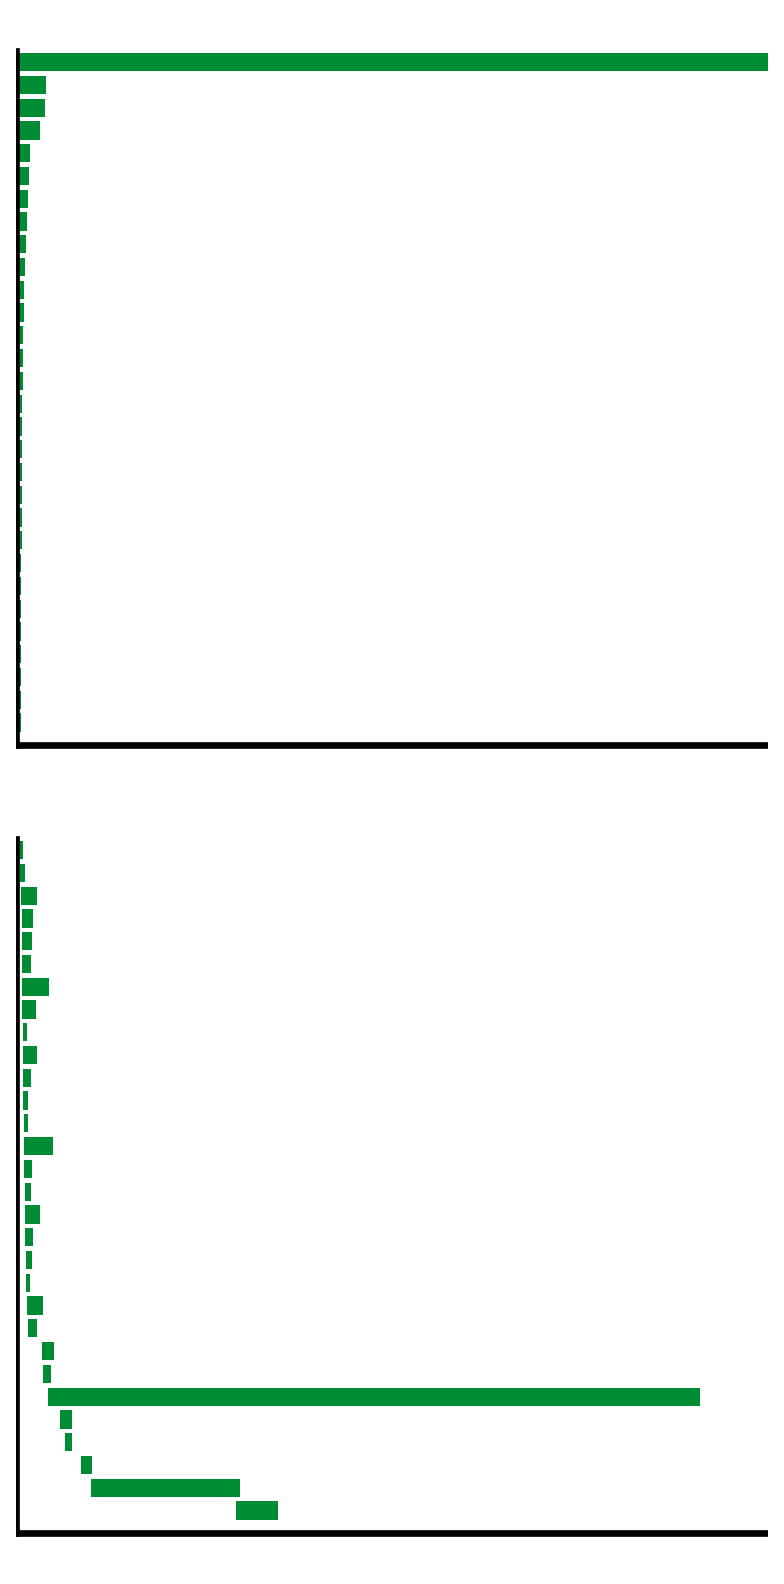

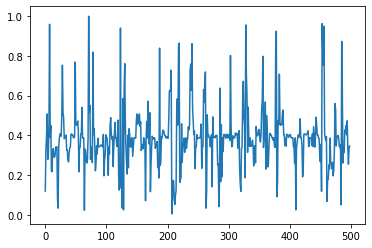

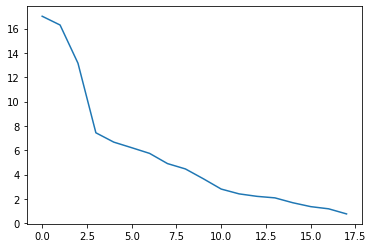

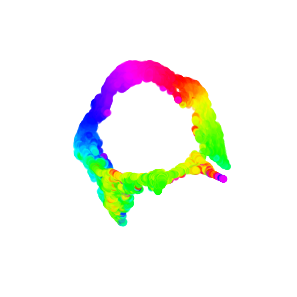

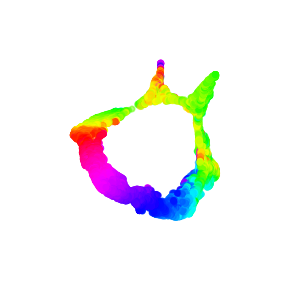

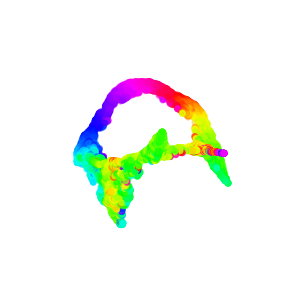

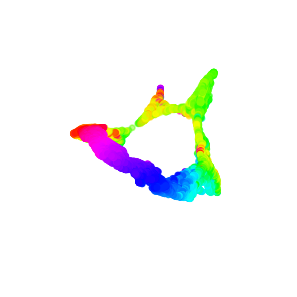

16.675413057602597 16.8970846264506


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 20.41432304382324
infinity 20.41432304382324


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


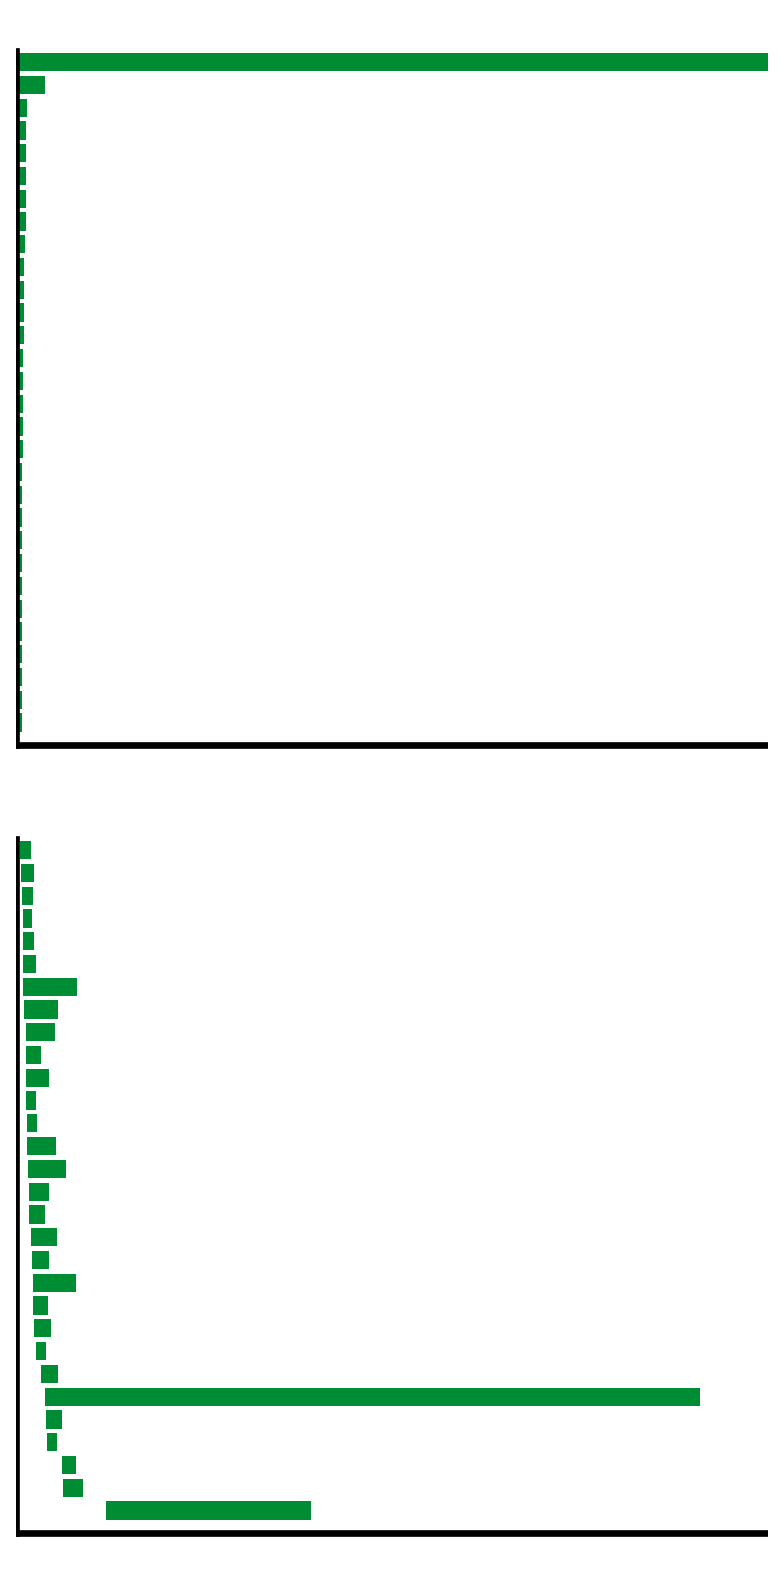

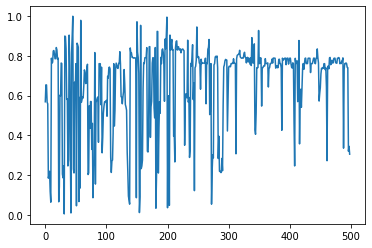

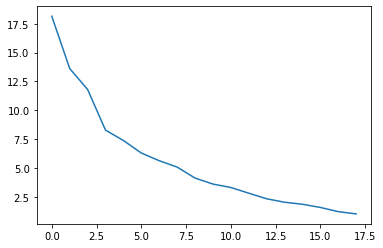

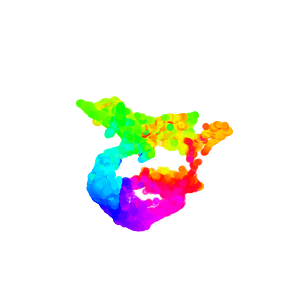

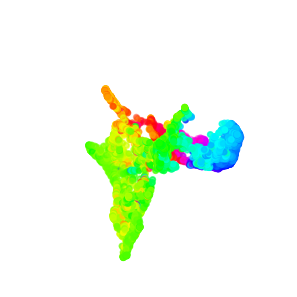

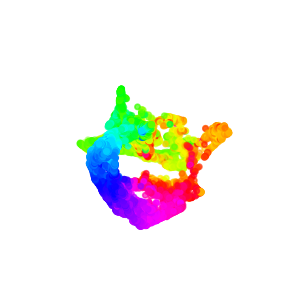

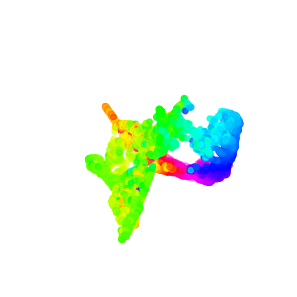

16.803473738153645 16.607233629574534


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 9.597153186798096
infinity 9.597153186798096


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


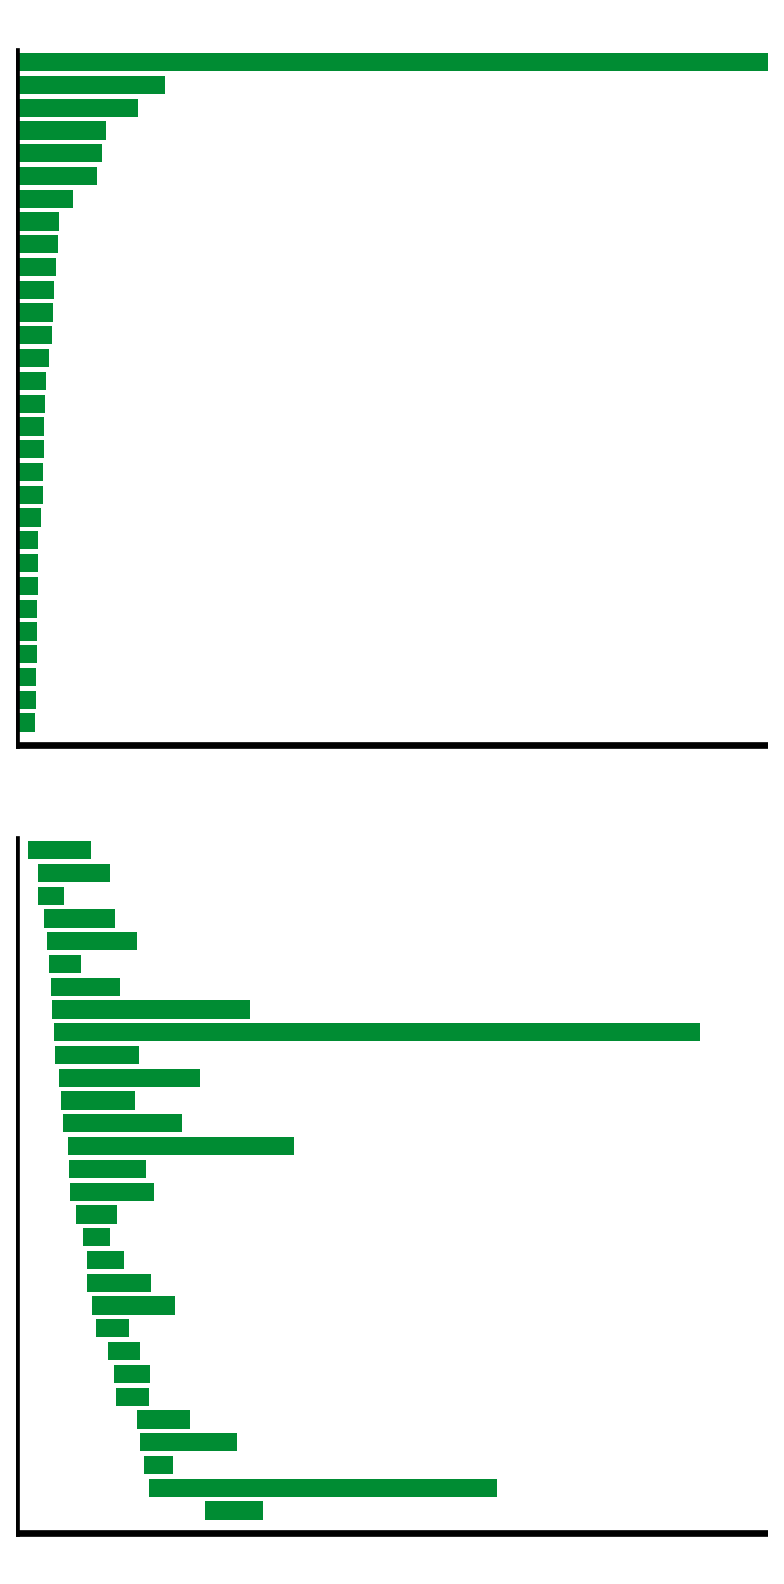

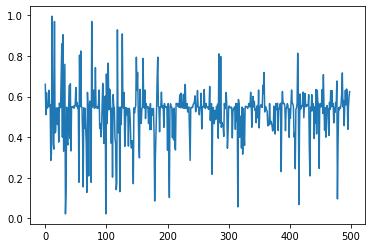

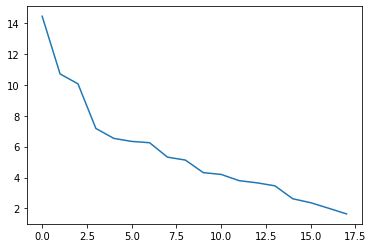

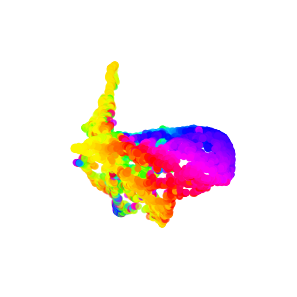

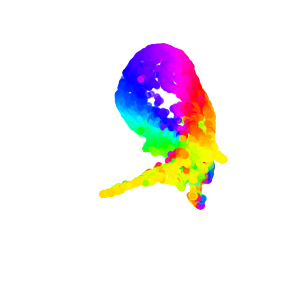

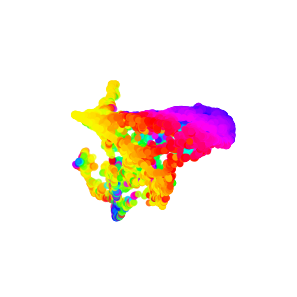

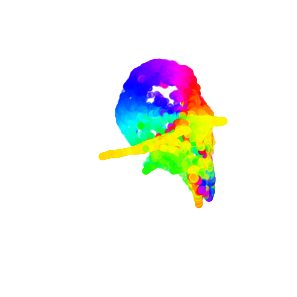

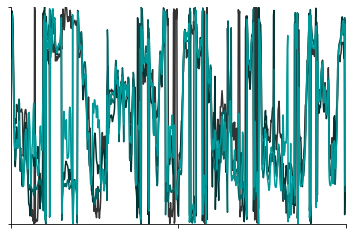

16.74772644602021 17.036895464210005


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 20.147346115112306
infinity 20.147346115112306


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


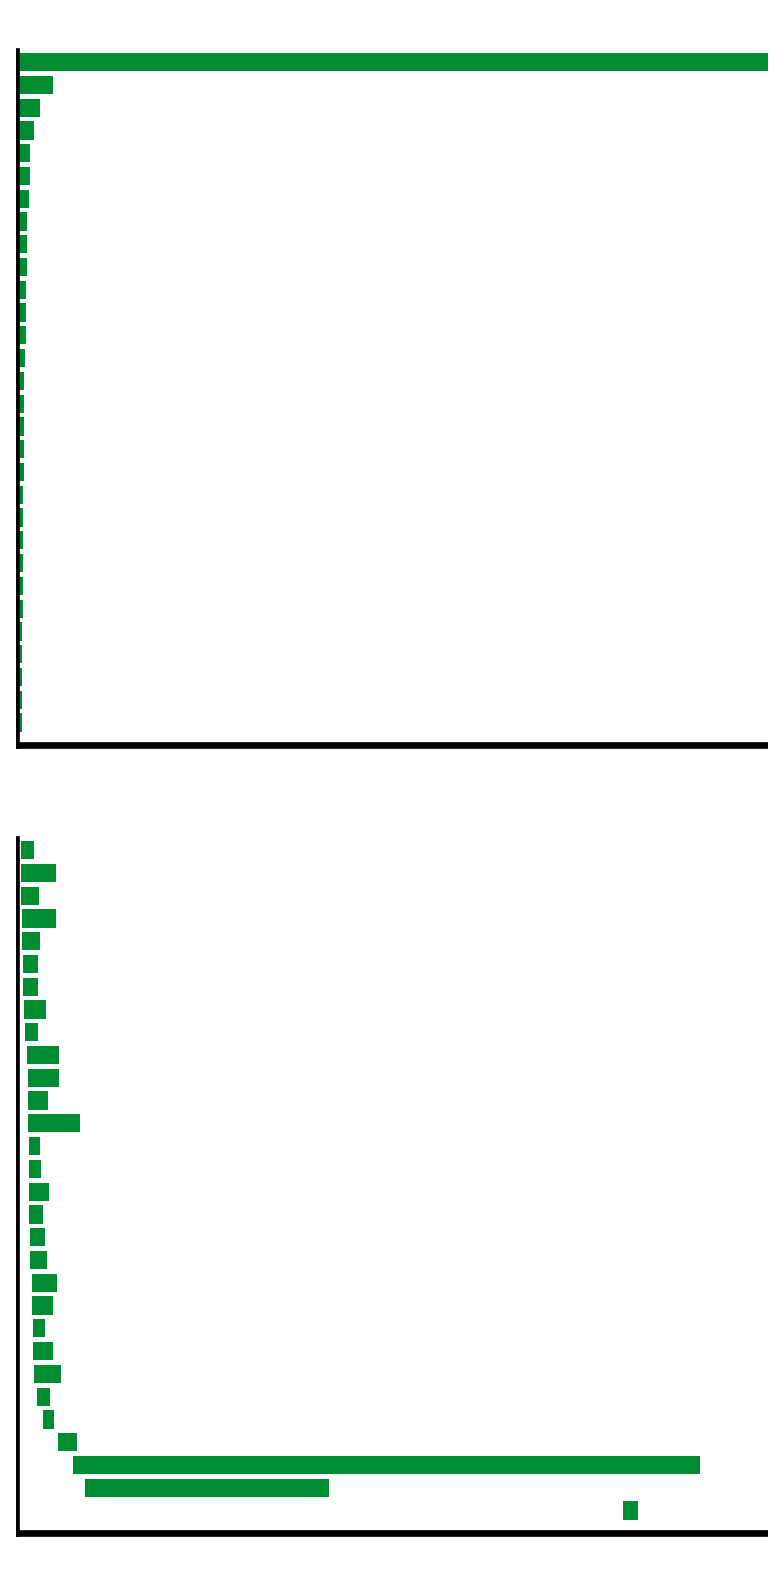

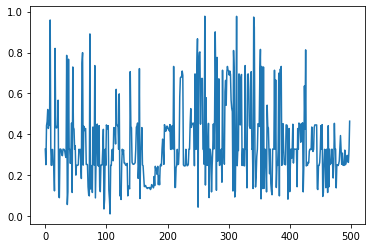

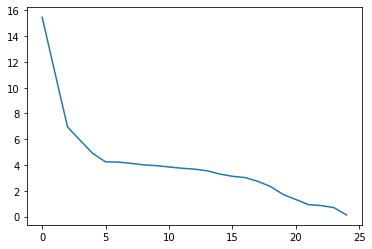

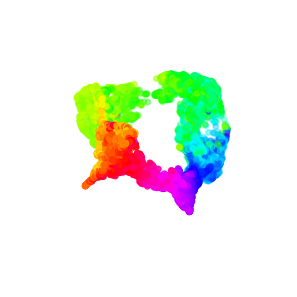

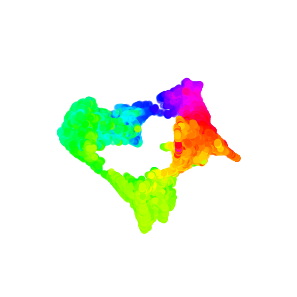

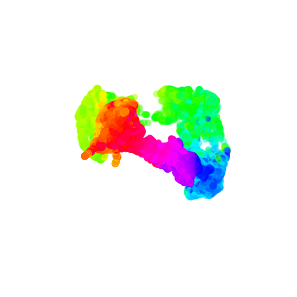

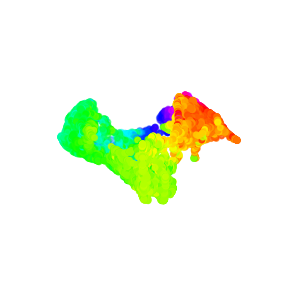

16.80604035968872 16.913282122088305


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 14.151137828826904
infinity 14.151137828826904


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


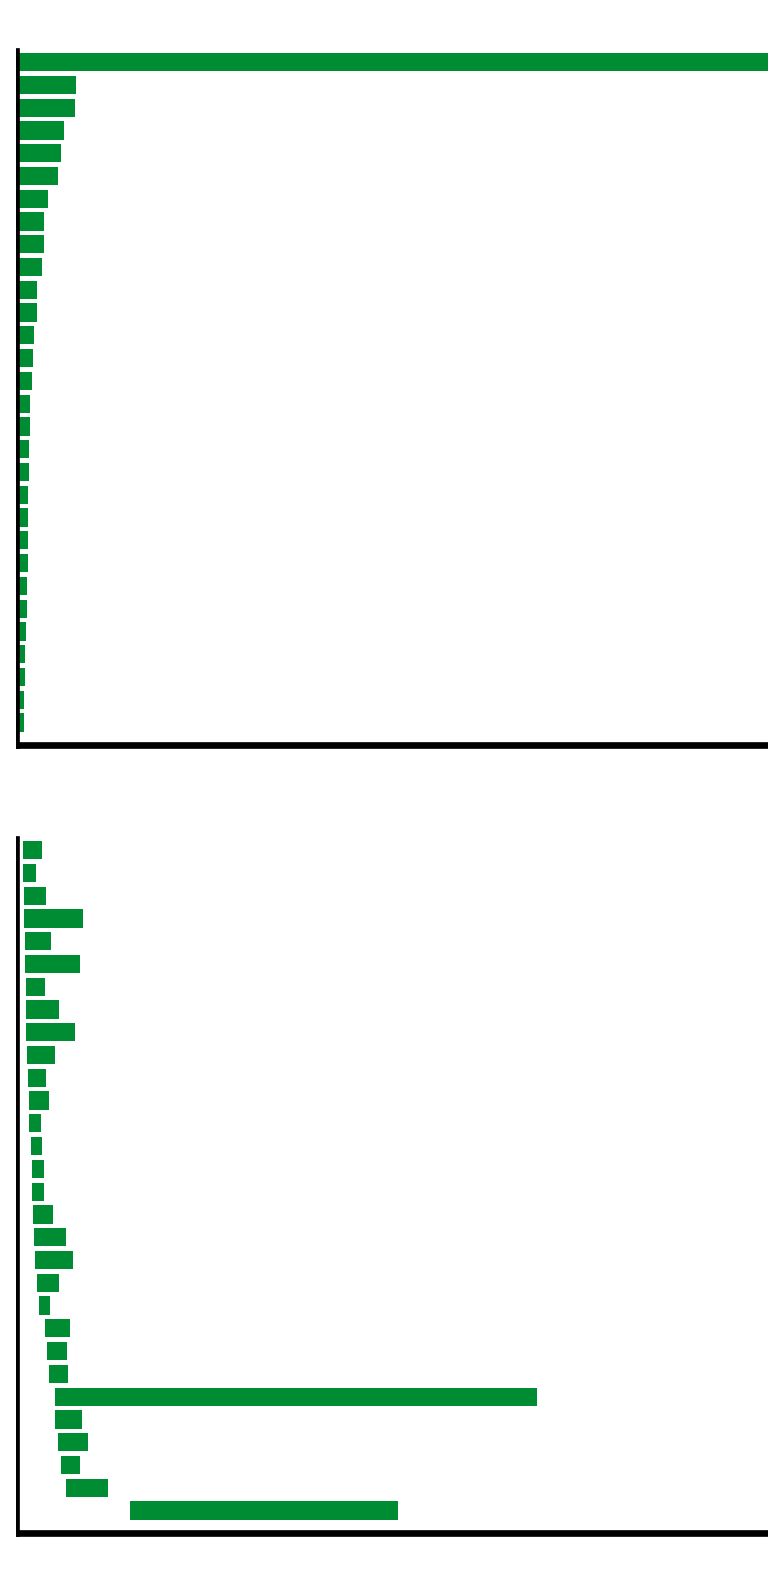

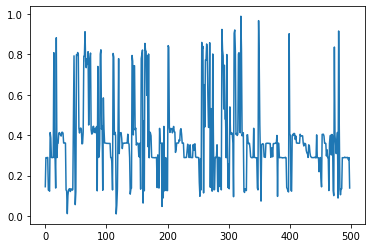

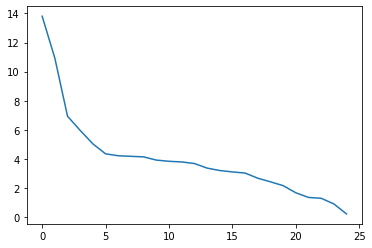

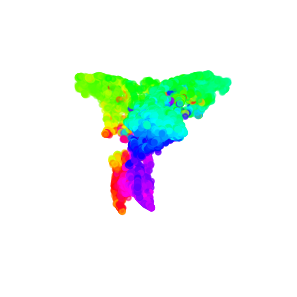

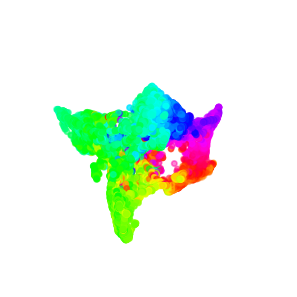

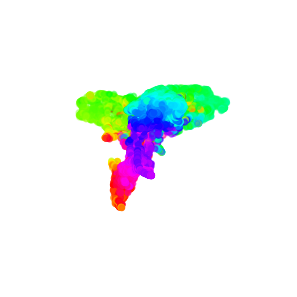

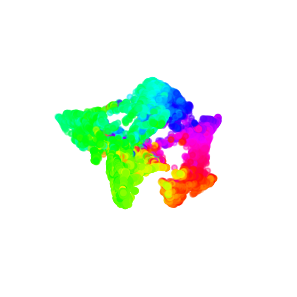

17.014575803007205 16.627053753931676


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 11.4647873878479
infinity 11.4647873878479


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


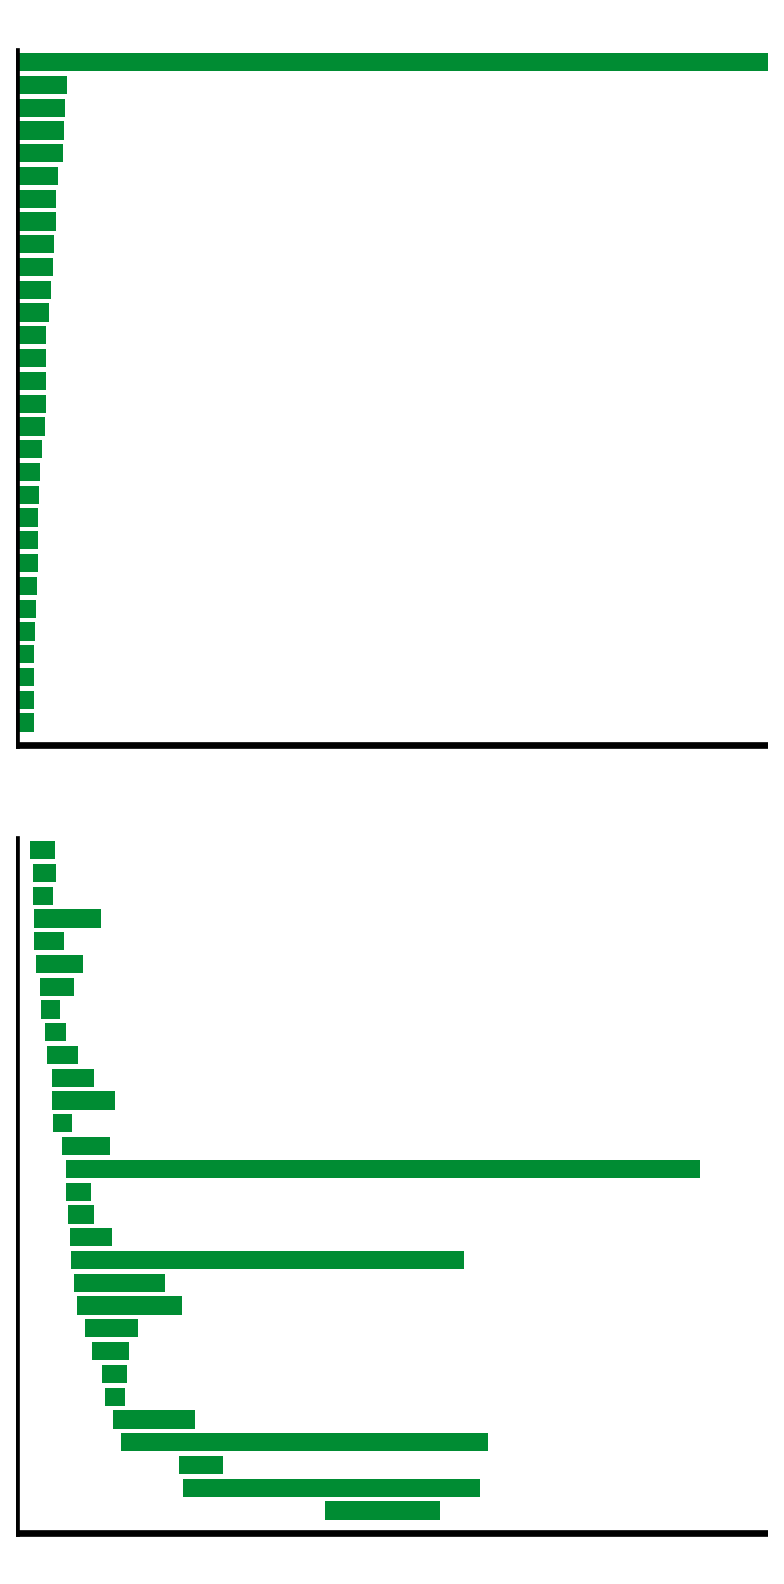

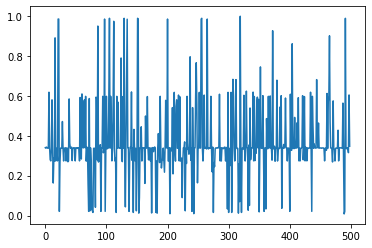

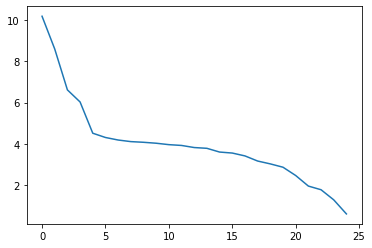

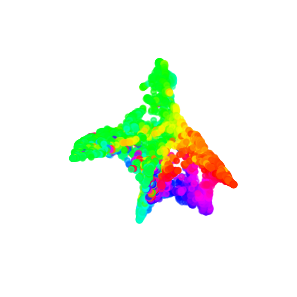

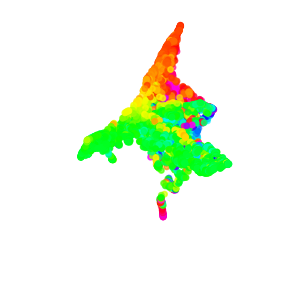

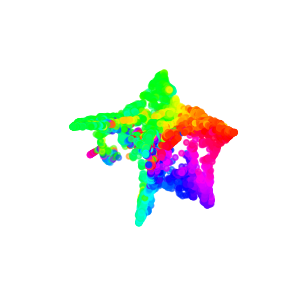

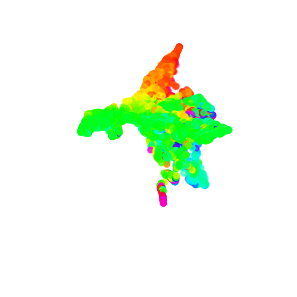

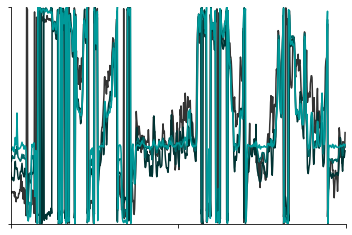

16.727550329638298 17.14239630310606


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 42.526625061035155
infinity 42.526625061035155


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


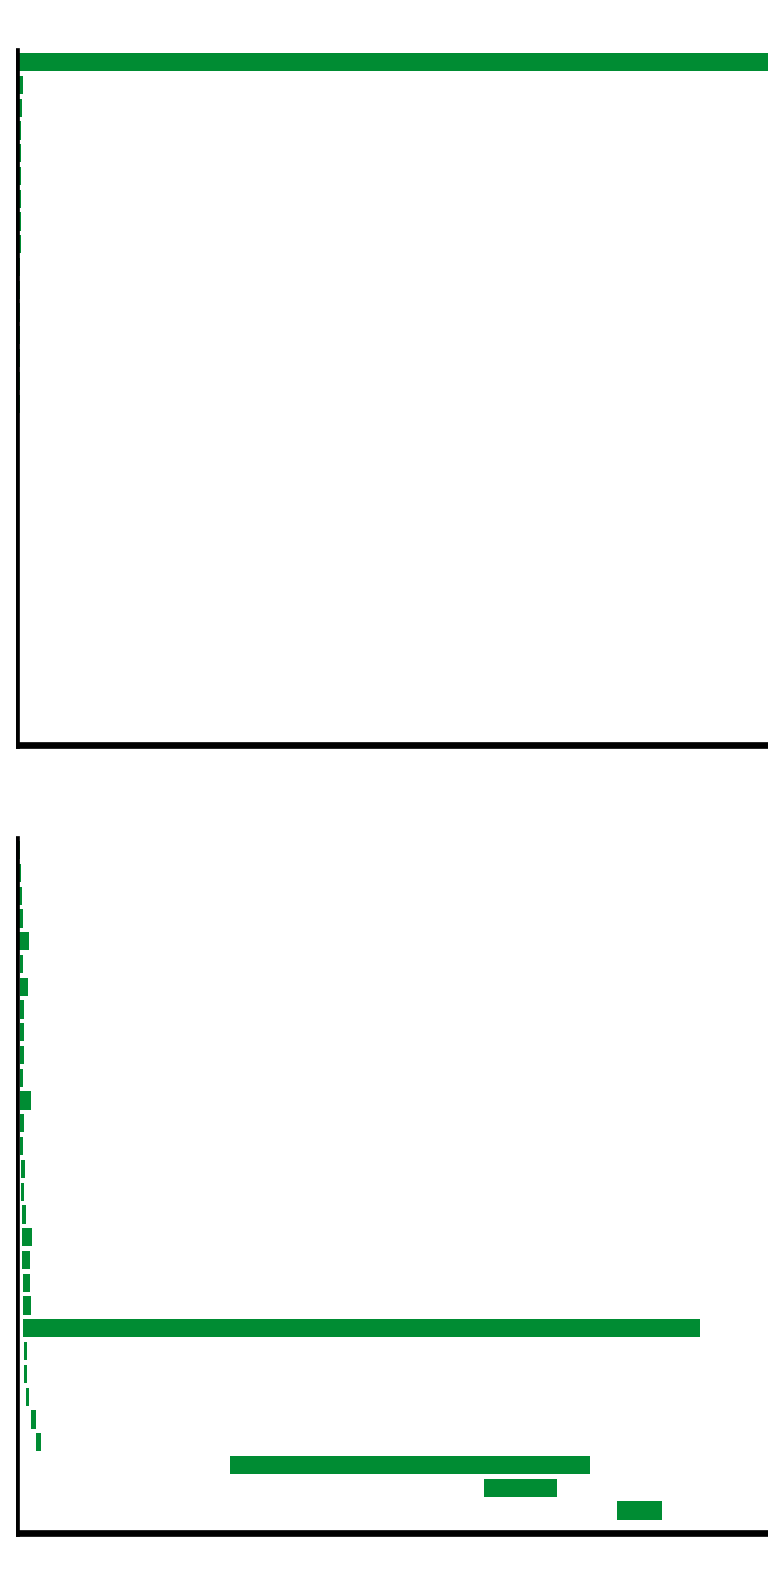

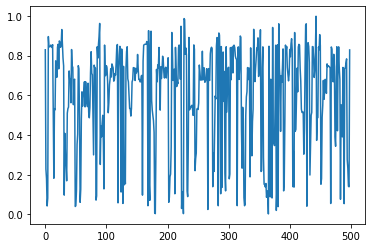

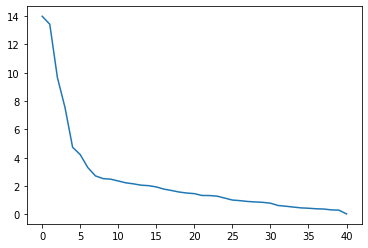

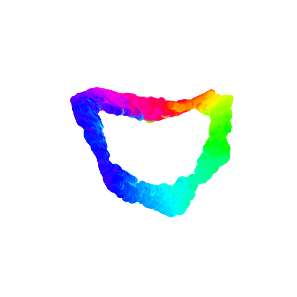

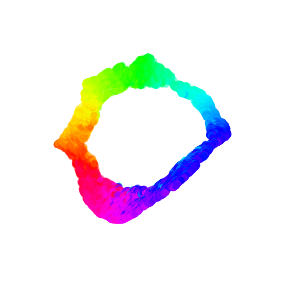

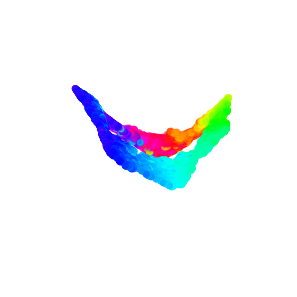

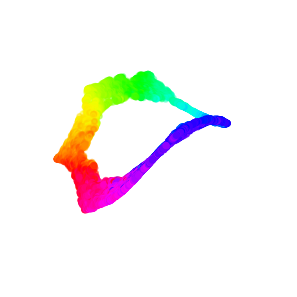

16.77695181763597 17.09341865514711


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 36.968680191040036
infinity 36.968680191040036


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


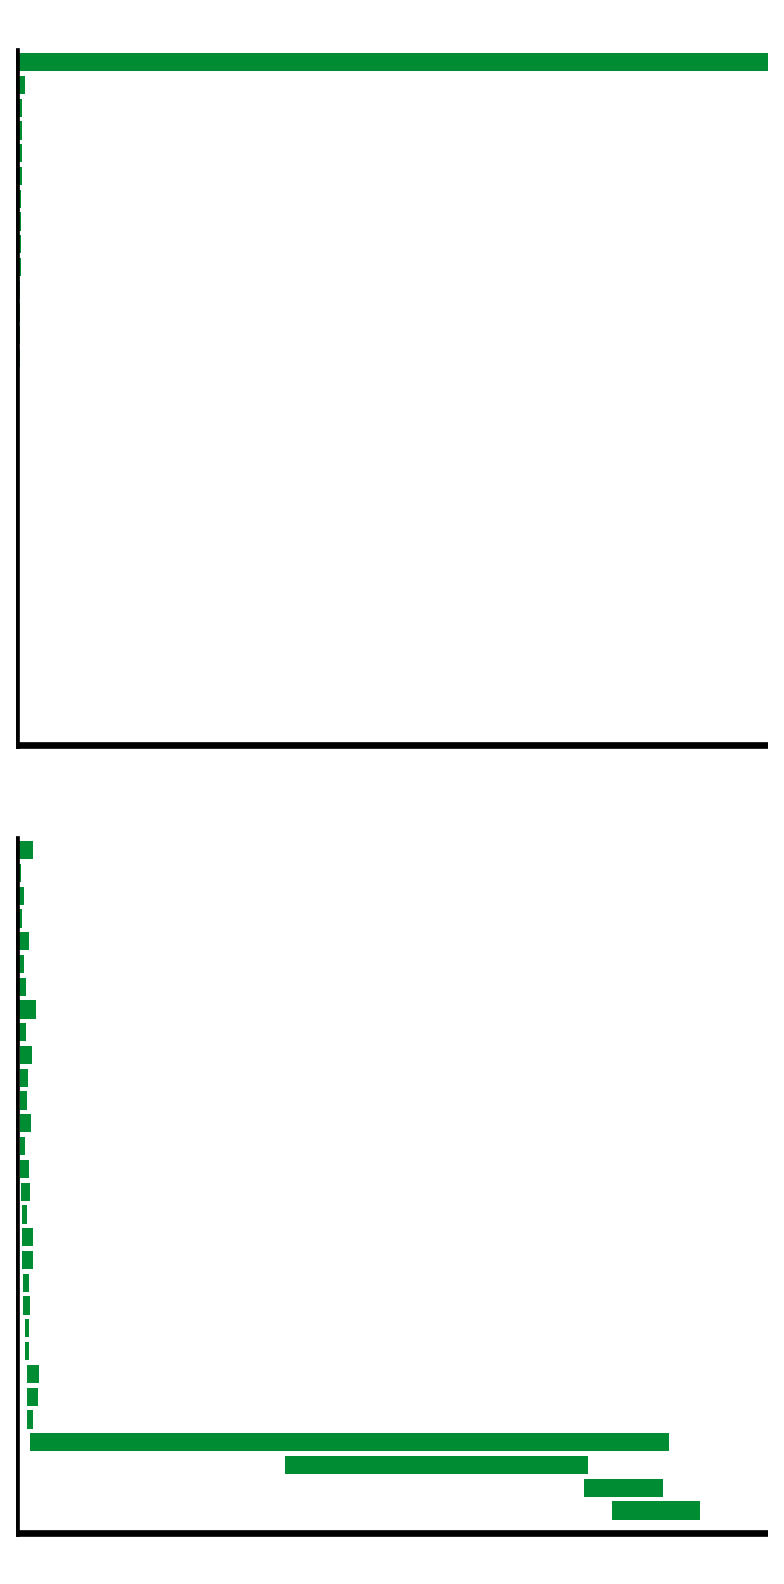

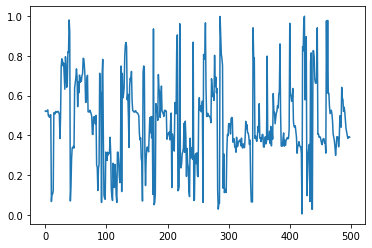

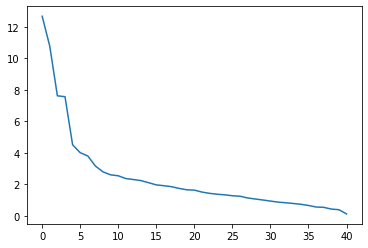

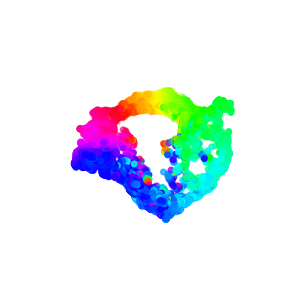

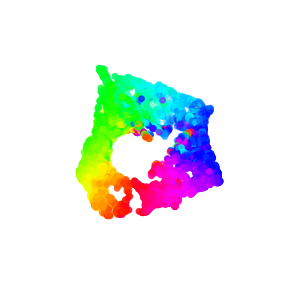

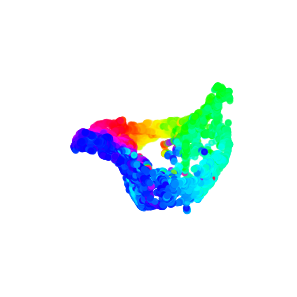

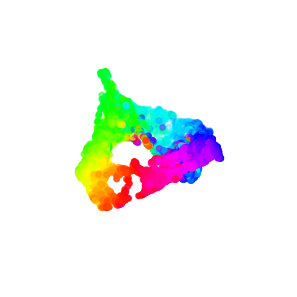

16.84609559887979 16.77605743282355


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 10.435474967956543
infinity 10.435474967956543


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


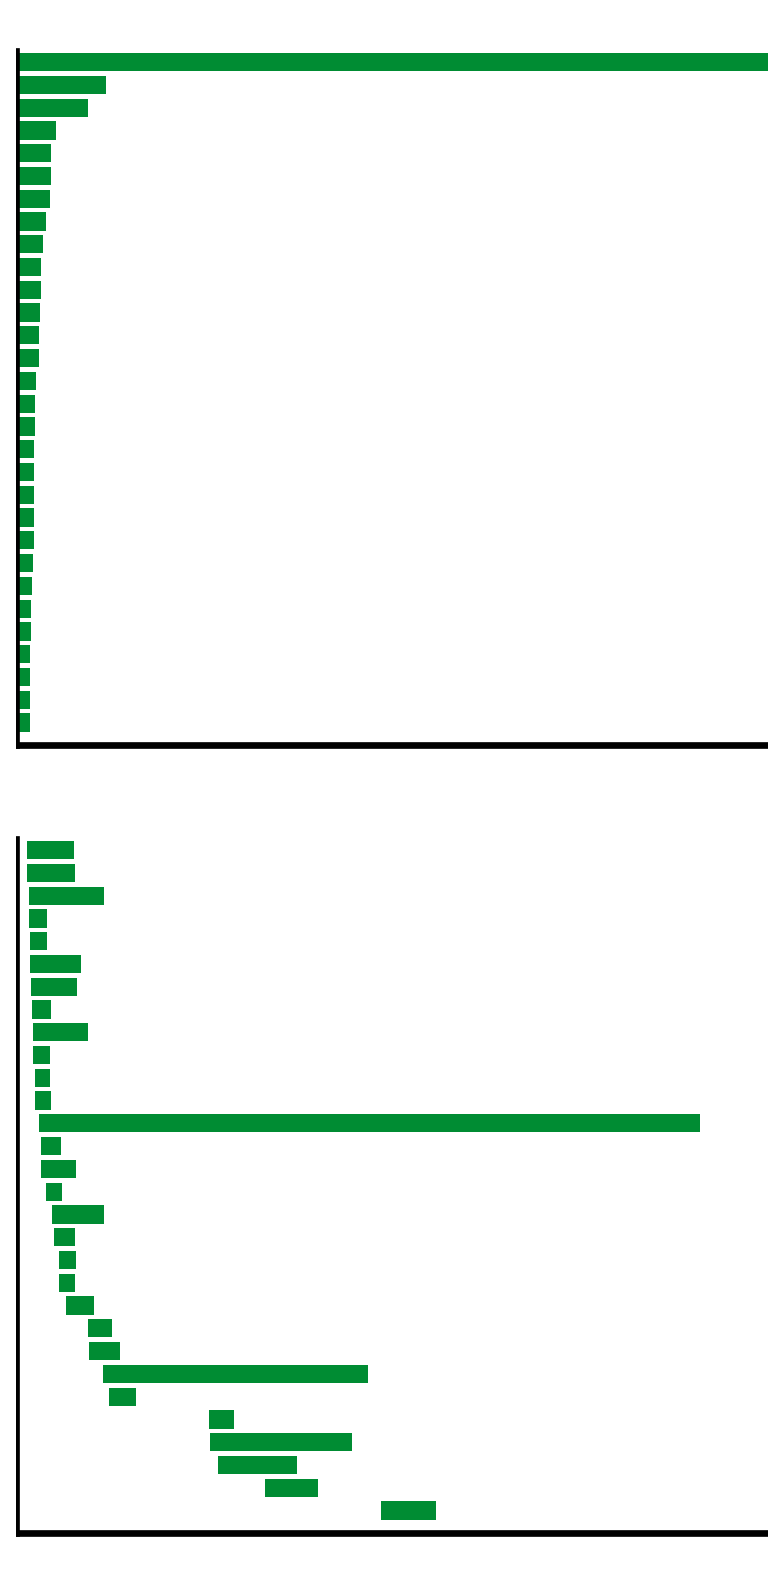

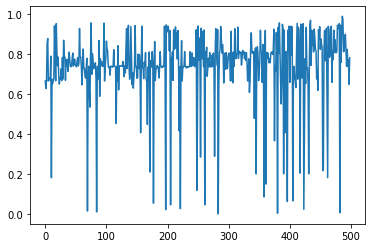

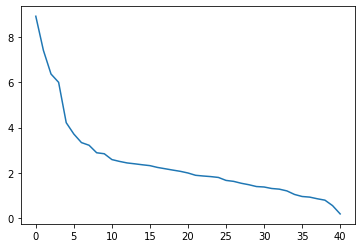

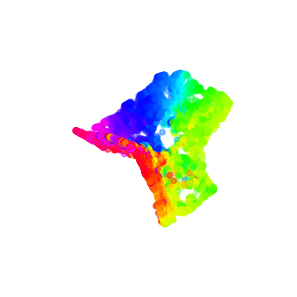

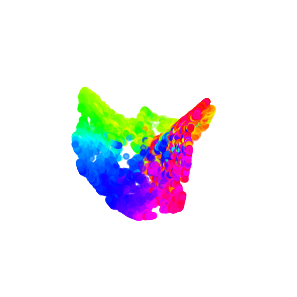

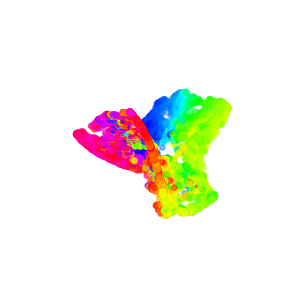

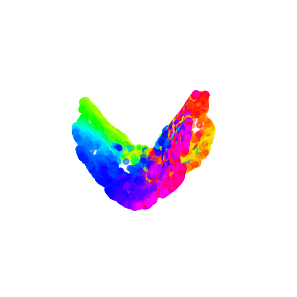

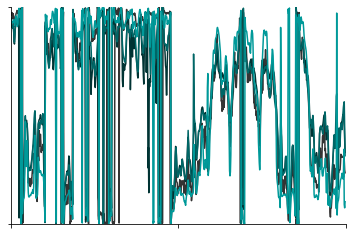

16.411387931248726 16.513404124299072


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 17.166419506072998
infinity 17.166419506072998


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


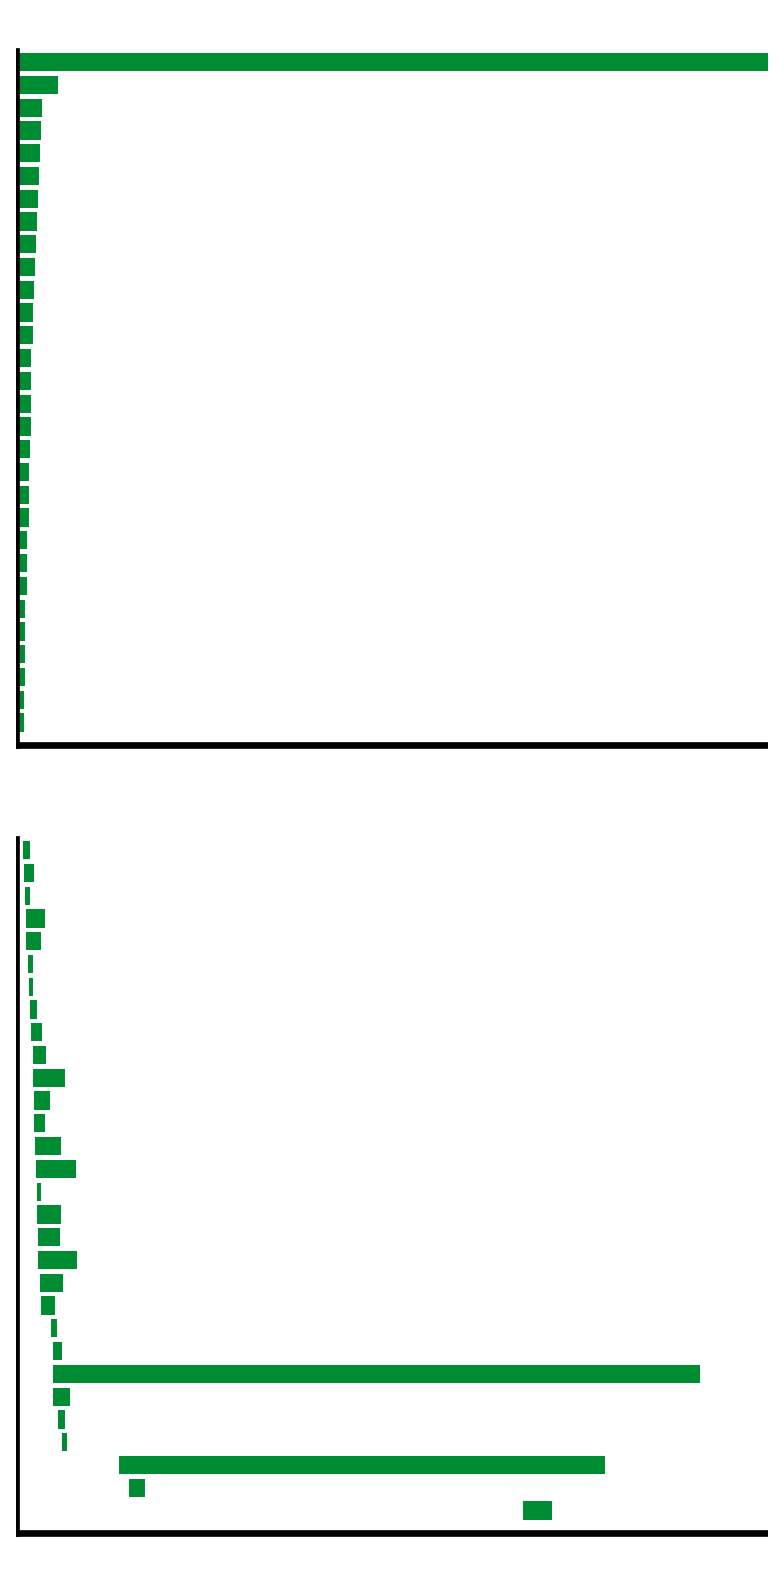

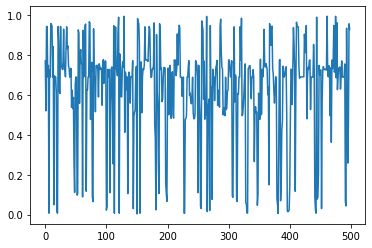

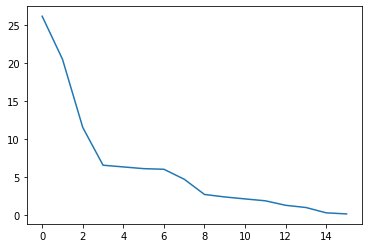

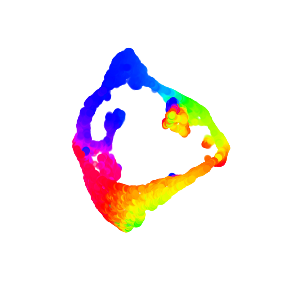

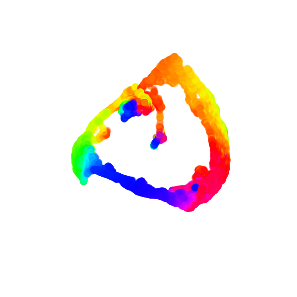

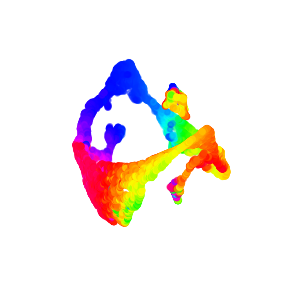

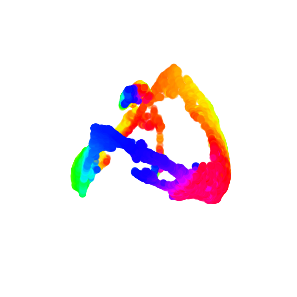

16.421283852404525 16.583590600646204


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 34.652616310119626
infinity 34.652616310119626


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


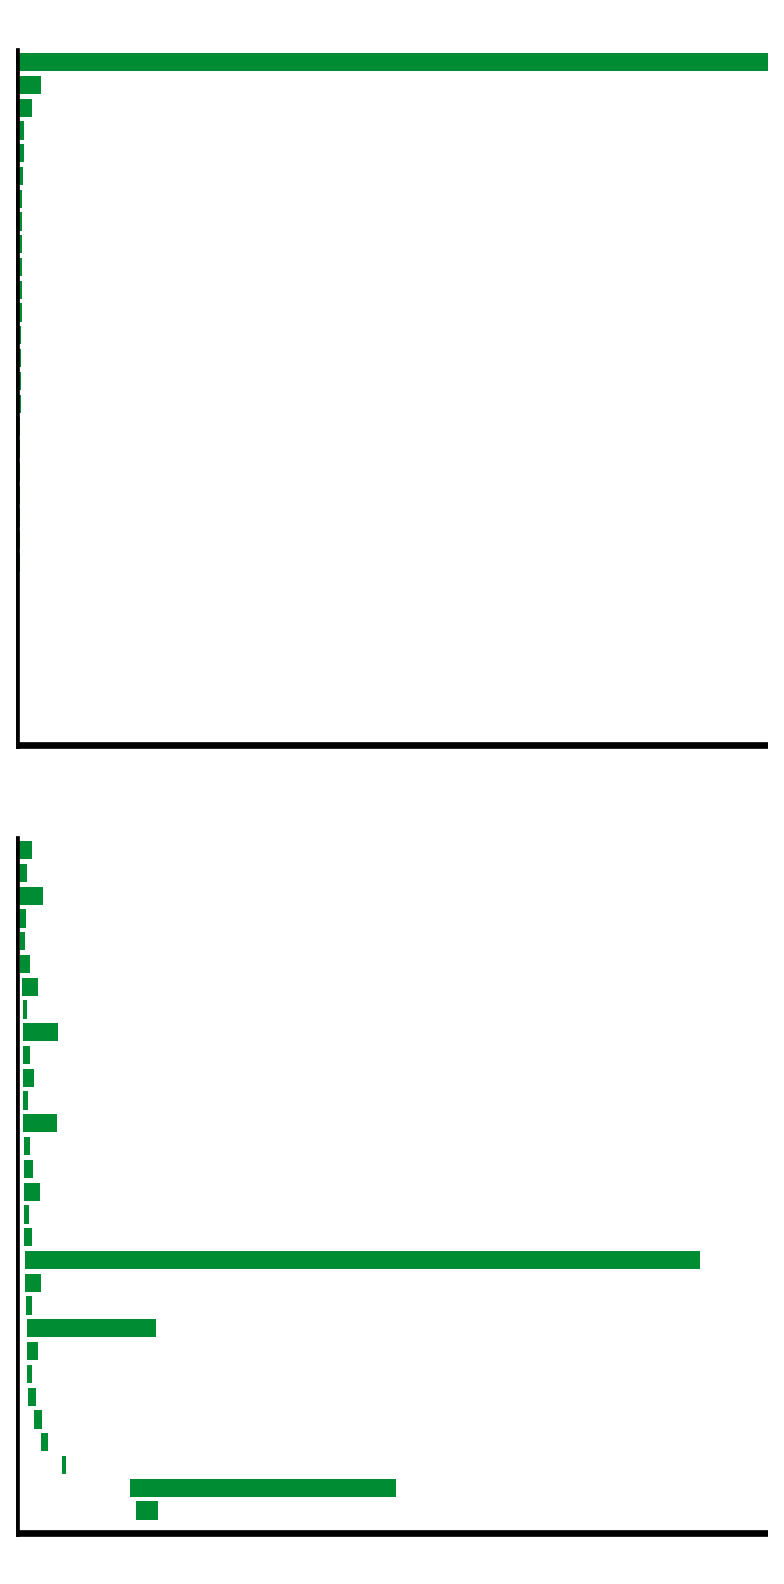

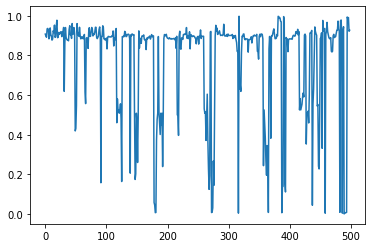

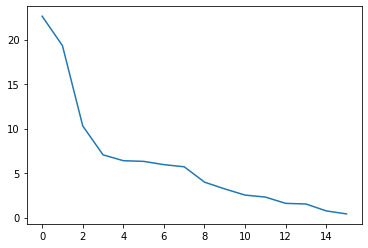

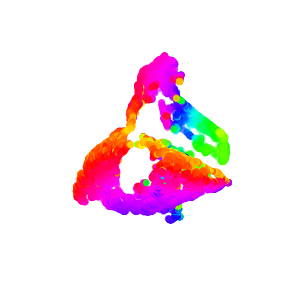

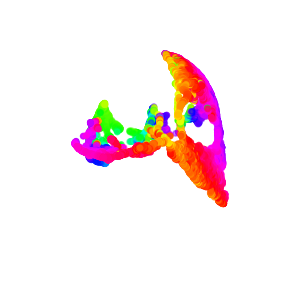

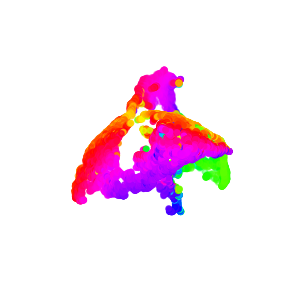

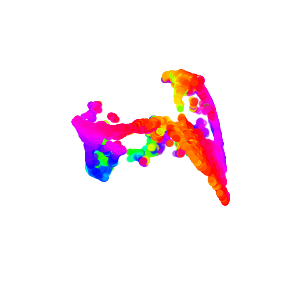

17.359787807298048 16.52176390356336


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:486: RuntimeWarning: divide by zero encountered in log
  d = -np.log(d)


0
infinity 18.757623863220214
infinity 18.757623863220214


C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:272: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v1[i, :] = [i, np.where(verts == edges[0][i])[0]]
C:\Users\Finnern\AppData\Local\Temp/ipykernel_20060/3954878722.py:273: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  v2[i, :] = [i, np.where(verts == edges[1][i])[0]]


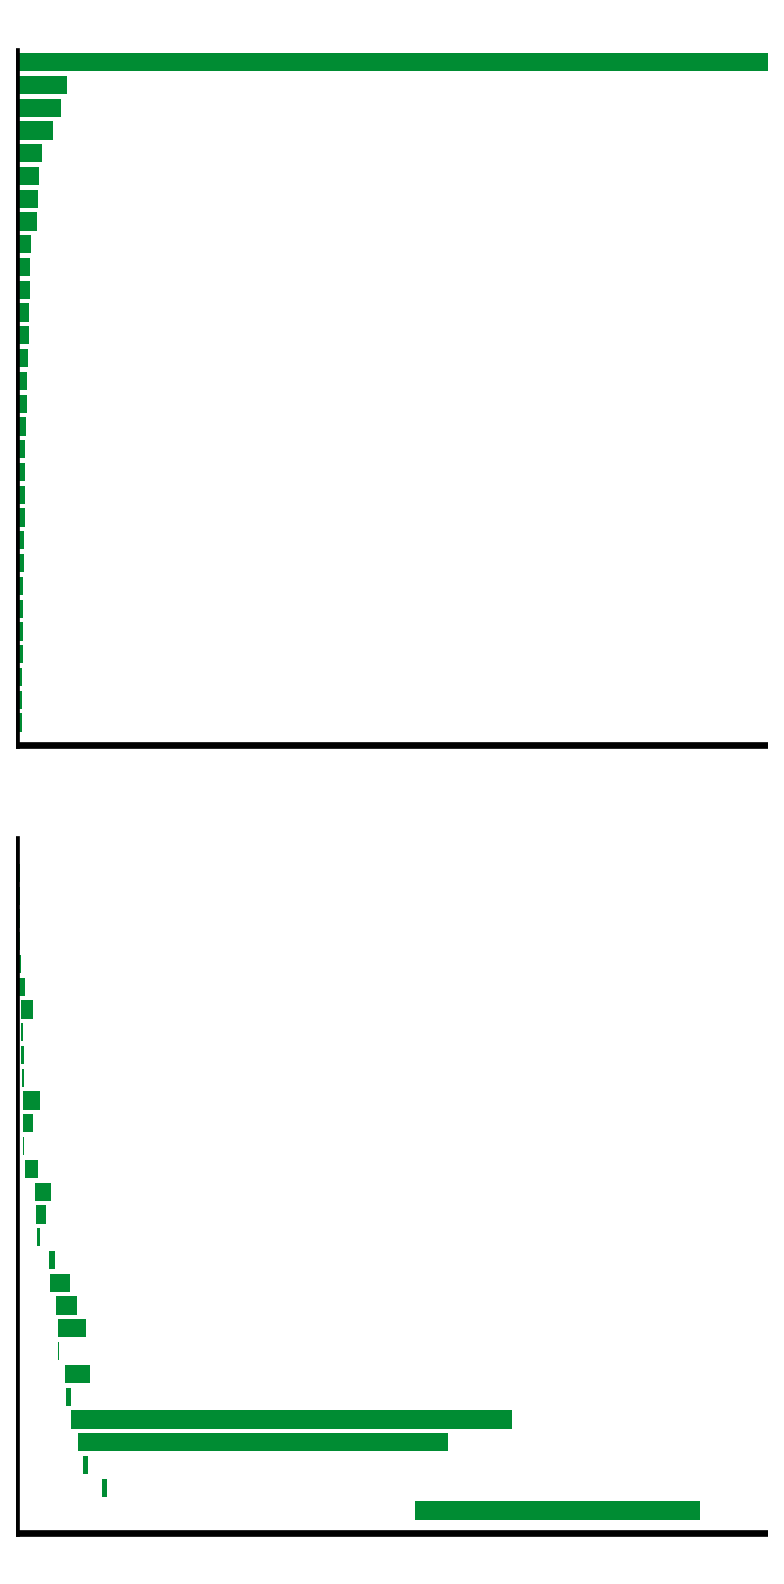

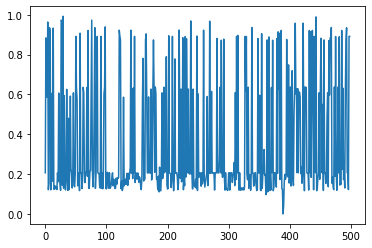

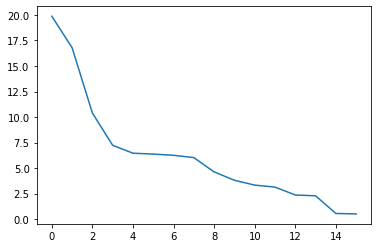

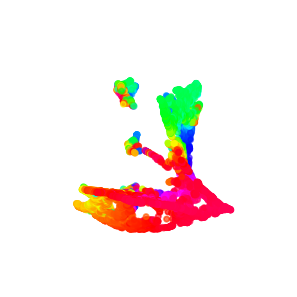

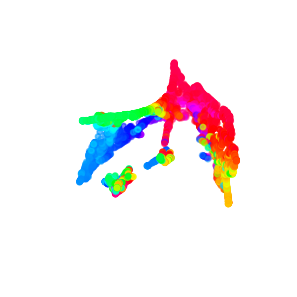

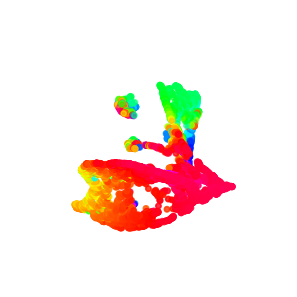

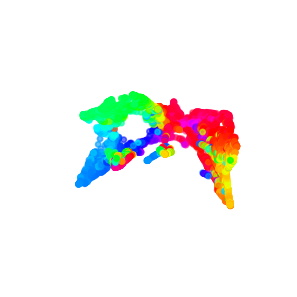

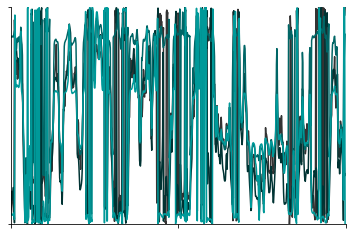

In [162]:
umap_class = umap.umap_.UMAP(n_neighbors=15, n_components=3, metric='euclidean', metric_kwds=None, output_metric='euclidean', 
                output_metric_kwds=None, n_epochs=None, learning_rate=1.0, init='spectral', min_dist=0.1, spread=1.0, 
                low_memory=True, n_jobs=-1, set_op_mix_ratio=1.0, local_connectivity=1.0, repulsion_strength=1.0)

cc_all = {}
for session in ('Mouse25-140130', # 10 neurons
                'Mouse17-130130', # 37 
                'Mouse28-140313',):
#                'Mouse12-120809'): # 62 neurons in total, 22 ADn, we don't really need to filter out on brain region to get HD in this session (and most others)
    ind, ccg, spikes_bin, hdd, xx, yy = load_data(session)
    for brain_state in ['Wake', 'REM', 'SWS']:
        spikes_bin[brain_state] = spikes_bin[brain_state][:, ind == np.argmax(np.bincount(ind))]
    cstate, cwake = {},{}
    for brain_state in ['Wake', 'REM', 'SWS']:
        nbs = 300
        dgms, rips_real, indstemp, movetimes1, var_exp = get_dgms(spikes_bin[brain_state],
                                                                  maxdim = 1, k = 1000, n_points = 500, 
                                                                  dim = 4, nbs = nbs, eps = 0., indstemp = [])
        fig = plot_barcode(dgms[0])
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_barcode.png', transparent = True)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_barcode.pdf', transparent = True)

        coords_ds =  get_coords_ds(rips_real, len(indstemp), ph_classes = [0,], 
                                      dec_thresh = 0.99, coeff = 47)
        plt.figure()
        plt.plot(coords_ds[0,np.argsort(indstemp)])
        coords_mod1 = get_coords_all(spikes_bin[brain_state], coords_ds, 
                                     np.arange(len(spikes_bin[brain_state])), 
                                     indstemp, dim = 6, bPred = False, bPCA = True)
        plt.show()
        if brain_state == 'Wake':
            ctemp = coords_mod1[:,0].copy()
        else:
            ctemp = get_coords_all(spikes_bin[brain_state], coords_ds, 
                                 np.arange(len(spikes_bin[brain_state])), 
                                 indstemp, dim = 6, spk2 =spikes_bin['Wake'],
                                   bPred = False, bPCA = False)[:,0]
        res = []
        pshift = []
        sig = 1
        for i in [0,1]:
            cc = (np.arctan2(gaussian_filter1d(np.sin(ctemp), sigma = sig), 
                                          gaussian_filter1d(np.cos(ctemp), sigma = sig))%(2*np.pi))
            if i==1:
                cc = 2*np.pi - cc 
            pshift.extend([np.arctan2(np.mean(np.sin(hdd-cc)),
                               np.mean(np.cos(hdd-cc)))])
            cc = (cc+pshift[i])%(2*np.pi)
            res.extend([np.sum(np.abs(np.arctan2(np.sin(hdd-cc),np.cos(hdd-cc))))])
        r = np.argmin(res)
        if r == 0:
            ctemp = (ctemp+pshift[r])%(2*np.pi)
            coords_mod1[:,0] = (coords_mod1[:,0] + pshift[r])%(2*np.pi)
        else:
            ctemp = ((2*np.pi-ctemp)+pshift[r])%(2*np.pi)
            coords_mod1[:,0] = ((2*np.pi-coords_mod1[:,0]) + pshift[r])%(2*np.pi)
        cwake[brain_state] = ctemp.copy()
        cstate[brain_state] = coords_mod1[:,0].copy()

        dim = 6
        dim_red_spikes_move_scaled = preprocessing.scale(spikes_bin[brain_state], axis = 0)
        dim_red_spikes_move_scaled, e1, e2, var_exp = pca(dim_red_spikes_move_scaled, dim = dim)
        dim_red_spikes_move_scaled /= np.sqrt(e2[:dim])

        plt.figure()
        plt.plot(var_exp)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_var_exp.png', transparent = True)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_var_exp.pdf', transparent = True)


        umap_proj = umap_class.fit_transform(dim_red_spikes_move_scaled)

        plt.hsv()
        fig = plt.figure(figsize = (10,10), dpi = 120)
        ax = fig.add_subplot(131, projection='3d')
        ax.scatter(umap_proj[:,0], umap_proj[:,1], umap_proj[:,2], s = 10, 
                   c = cstate[brain_state])
        ax.axis('off')
        ax.view_init(60,180)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap1.png', transparent = True)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap1.pdf', transparent = True)

        fig = plt.figure(figsize = (10,10), dpi = 120)
        ax = fig.add_subplot(131, projection='3d')
        ax.scatter(umap_proj[:,0], umap_proj[:,1], umap_proj[:,2], s = 10, 
                   c = cstate[brain_state])
        ax.axis('off')
        ax.view_init(60,60)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap2.png', transparent = True)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap2.pdf', transparent = True)

        fig = plt.figure(figsize = (10,10), dpi = 120)
        ax = fig.add_subplot(131, projection='3d')
        ax.scatter(umap_proj[:,0], umap_proj[:,1], umap_proj[:,2], s = 10, 
                   c = cstate[brain_state])
        ax.axis('off')
        ax.view_init(30,180)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap3.png', transparent = True)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap3.pdf', transparent = True)

        fig = plt.figure(figsize = (10,10), dpi = 120)
        ax = fig.add_subplot(131, projection='3d')
        ax.scatter(umap_proj[:,0], umap_proj[:,1], umap_proj[:,2], s = 10, 
                   c = cstate[brain_state])
        ax.axis('off')
        ax.view_init(30,60)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap4.png', transparent = True)
        fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_umap4.pdf', transparent = True)
        plt.show()

    fig = plt.figure()
    ax = fig.add_subplot(111)
    t0, t1 = 400, 1200
    ax.plot(hdd[t0:t1], c = [0.2,0.2,0.2], label = 'Rec Wake')
    it = 1
    for brain_state in cwake:
        ax.plot(cwake[brain_state][t0:t1],c = [0.,0.2*it,0.2*it], label = 'Dec ' + brain_state)
        it += 1
    ax.set_xlim([0,800])
    ax.set_ylim([0,2*np.pi])
    ax.set_xticks([0,400,800])
    ax.set_yticks([0,2*np.pi])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
#    plt.legend(prop={'size': 8})

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_hd.png', transparent = True)
    fig.savefig('Figs/npoints500/' + session + '_' + brain_state + '_hd.pdf', transparent = True)
    plt.show()
    
        
    num_neurons = len(spikes_bin['Wake'][0,:])
    bins = np.linspace(0,2*np.pi,61)
    hd_cumulative, _, __ = binned_statistic(hdd, np.ones(len(hdd)), statistic = 'sum', bins=bins, range=None)
    hd_cumulative[np.isnan(hd_cumulative)] = 0
    hd_cumulative /= np.sum(hd_cumulative)
    for i in range(num_neurons):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(bins, np.concatenate(([hd_cumulative[-1]], hd_cumulative)), lw = 5, ls = '-', alpha = 0.5, c = [0.4,0.4,0.4], label = 'Cumulative')

        rec = binned_statistic(hdd, spikes_bin['Wake'][:,i], statistic = 'mean', bins=bins, range=None)[0]
        rec[np.isnan(rec)] = 0
        rec /= np.max(rec)
        ax.plot(bins, np.concatenate(([rec[-1]], rec)), lw = 5, ls = '-', alpha = 0.9, c = [0.2,0.2,0.2], label = 'Rec Wake')
        it = 1
        for brain_state in cwake:
            dec = binned_statistic(cwake[brain_state], spikes_bin['Wake'][:,i], statistic = 'mean', bins=bins, range=None)[0]
            dec[np.isnan(dec)] = 0
            dec /= np.max(dec)
            ax.plot(bins, np.concatenate(([dec[-1]], dec)), lw = 5, ls = '-', alpha = 0.9, c = [0.,0.2*it,0.2*it], label = 'Dec ' + brain_state)
            it += 1
        ax.set_rticks([0.33, 0.66,1]) 
        ax.set_yticklabels('')
        ax.set_xticklabels('')
        ax.set_rlim([0,1.1])

        plt.savefig('Figs/npoints500/' + session + 'hd_wake_' + str(i) + '.png', transparent = True)
        plt.close()
        
    for i in range(num_neurons):
        fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
        ax.plot(bins, np.concatenate(([hd_cumulative[-1]], hd_cumulative)), lw = 5, ls = '-', alpha = 0.5, c = [0.4,0.4,0.4], label = 'Cumulative')

        rec = binned_statistic(hdd, spikes_bin['Wake'][:,i], statistic = 'mean', bins=bins, range=None)[0]
        rec[np.isnan(rec)] = 0
        rec /= np.max(rec)
        ax.plot(bins, np.concatenate(([rec[-1]], rec)), lw = 5, ls = '-', alpha = 0.9, c = [0.2,0.2,0.2], label = 'Rec Wake')
        it = 1
        for brain_state in cstate:
            dec = binned_statistic(cstate[brain_state], spikes_bin[brain_state][:,i], statistic = 'mean', bins=bins, range=None)[0]
            dec[np.isnan(dec)] = 0
            dec /= np.max(dec)
            ax.plot(bins, np.concatenate(([dec[-1]], dec)), lw = 5, ls = '-', alpha = 0.9, c = [0.,0.2*it,0.2*it], label = 'Dec ' + brain_state)
            it += 1
        ax.set_rticks([0.33, 0.66,1]) 
        ax.set_yticklabels('')
        ax.set_xticklabels('')
        ax.set_rlim([0,1.1])

        plt.savefig('Figs/npoints500/' + session + 'hd_state_' + str(i) + '.png', transparent = True)
        plt.close()
 
    